# Load Data

In [1]:
'''
This script optimizes logistic nonlinearities for a variety of Gaussian distribtuions and plots the optimal parameters.
Author: Jonathan Gant
Date: 29.08.2024
'''

import numpy as np
import matplotlib.pyplot as plt
from utilities import logistic_func, calc_MI, calc_entropy
from tqdm import tqdm
import h5py
import os
import bottleneck as bn

# Set random seed for reproducibility
np.random.seed(0)

# load in the data
# all_gabor_responses = h5py.File('../results/new_nat_videos_gabor_responses_full_res_z_score.h5', 'r')
all_gabor_responses = h5py.File('../results/new_nat_videos_gabor_responses_full_res_z_score_more_freq.h5', 'r')
# all_gabor_responses_low_freq = h5py.File('../results/new_nat_videos_gabor_responses_full_res_more_low_freq_z_score.h5', 'r')
# all_gabor_responses_eye_movements = h5py.File('../results/new_nat_videos_gabor_responses_full_res_more_low_freq_z_score_eye_movements.h5', 'r')
# all_gabor_responses_eye_movements_long = h5py.File('../results/new_nat_videos_gabor_responses_full_res_more_low_freq_z_score_eye_movements_2s_interval_stat_only.h5', 'r')

# all_gabor_responses = h5py.File('../results/new_nat_vids_gabor_responses_full_res.h5', 'r')

# video size
resolution_height = 1080
resolution_width = 1920

# fov
horizontal_fov = 92
vertical_fov = 61

# conversion factor of pixels to degrees
horizontal_pixels_per_degree = resolution_width / horizontal_fov
vertical_pixels_per_degree = resolution_height / vertical_fov

# average of the conversion factors to the nearest integer
pixels_per_degree = np.ceil((horizontal_pixels_per_degree + vertical_pixels_per_degree) / 2)
print(pixels_per_degree)

# data hyperparameters
orientation_arr = all_gabor_responses['orientation_arr'][()]
phase_arr = all_gabor_responses['phase_arr'][()]
position_arr = all_gabor_responses['position_arr'][()]
wavelength_arr = all_gabor_responses['wavelength_arr'][()]
# wavelength_arr_low_freq = all_gabor_responses_low_freq['wavelength_arr'][()]
freq_arr = pixels_per_degree / wavelength_arr
# freq_arr_low_freq = pixels_per_degree / wavelength_arr_low_freq
filter_size = (resolution_height, resolution_width)
print(freq_arr)
low_spatial_freq_idx = np.arange(0, 31)
high_spatial_freq_idx = np.arange(35, 70)

20.0
[0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14 0.15
 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28 0.29
 0.3  0.31 0.32 0.33 0.34 0.35 0.36 2.   2.12 2.24 2.36 2.48 2.6  2.72
 2.84 2.96 3.08 3.2  3.32 3.44 3.56 3.68 3.8  3.92 4.04 4.16 4.28 4.4
 4.52 4.64 4.76 4.88 5.   5.12 5.24 5.36 5.48 5.6  5.72 5.84 5.96 6.08]


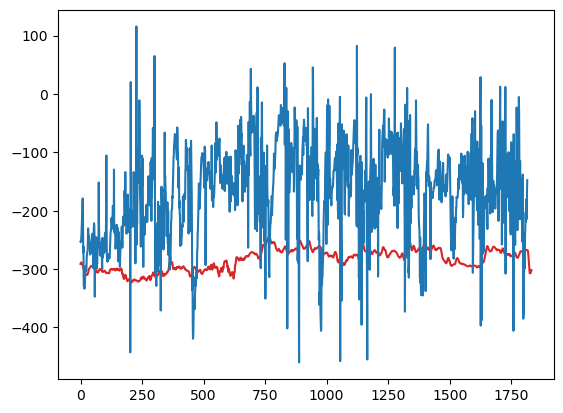

In [2]:
plt.plot(all_gabor_responses['field']['stationary_1'][0, 0, 0, 4, :], color='tab:red')
plt.plot(all_gabor_responses['field']['moving_1'][0, 0, 0, 4, :], color='tab:blue')

## Compute SD

### Only full frequency

In [ ]:
import bottleneck as bn

environments = ['field', 'forest', 'orchard', 'tall_grass', 'pond']

stationary_stim_SD = []
moving_stim_SD = []
stationary_stim = []
moving_stim = []

fps = 30
window_length = np.array([1, 2, 5, 10, 20]) # seconds
window_size = window_length * fps
print(window_size)
num_samples = 1740

# get the responses for each environment
for i in range(len(window_size)):
    stationary_stim_SD_temp = []
    moving_stim_SD_temp = []
    # stationary_stim_temp = []
    # moving_stim_temp = []
    for env_key in environments:
        all_gabor_responses_env = all_gabor_responses[env_key]
        print(all_gabor_responses_env.keys())
        for vid_key in all_gabor_responses_env.keys():
            # compute the moving SD
            resp_SD = bn.move_std(all_gabor_responses_env[vid_key][()], window=window_size[i], min_count=window_size[i], axis=-1)[:, :, low_spatial_freq_idx, :, :num_samples]
            if 'stationary' in vid_key:
                stationary_stim_SD_temp.append(resp_SD)
                # stationary_stim_temp.append(all_gabor_responses_env[vid_key][()])
            if 'moving' in vid_key and 'free_moving' not in vid_key:
                moving_stim_SD_temp.append(resp_SD)
                # moving_stim_temp.append(all_gabor_responses_env[vid_key][()])
    stationary_stim_SD.append(stationary_stim_SD_temp)
    moving_stim_SD.append(moving_stim_SD_temp)
    # stationary_stim.append(stationary_stim_temp)
    # moving_stim.append(moving_stim_temp)

In [51]:
import bottleneck as bn
from joblib import Parallel, delayed
from tqdm import tqdm

environments = ['field', 'forest', 'orchard', 'tall_grass', 'pond']

fps = 30
window_length = np.array([5]) # np.array([1, 2, 5, 10, 20]) # seconds
window_size = window_length * fps
num_samples = 1740

# Pre-load all data into memory for faster access
all_gabor_data = {}
for env_key in tqdm(environments, desc="Pre-loading environments"):
    env_data = {}
    for vid_key in tqdm(all_gabor_responses[env_key].keys(), desc=f"Loading {env_key}", leave=False):
        env_data[vid_key] = all_gabor_responses[env_key][vid_key][()]
    all_gabor_data[env_key] = env_data

def compute_sd_for_video(data, window, idx, num_samples):
    # data: shape (..., time)
    return bn.move_std(data, window=window, min_count=window, axis=-1)[:, :, idx, :, :num_samples]

stationary_stim_SD = []
moving_stim_SD = []

for i, win in enumerate(tqdm(window_size, desc="Window sizes")):
    stationary_stim_SD_temp = []
    moving_stim_SD_temp = []
    for env_key in tqdm(environments, desc="Environments", leave=False):
        env_data = all_gabor_data[env_key]
        vid_keys = list(env_data.keys())
        results = Parallel(n_jobs=-1)(
            delayed(compute_sd_for_video)(env_data[vid_key], win, low_spatial_freq_idx, num_samples)
            for vid_key in tqdm(vid_keys, desc=f"Processing {env_key}", leave=False)
        )
        for vid_key, resp_SD in zip(vid_keys, results):
            if 'stationary' in vid_key:
                stationary_stim_SD_temp.append(resp_SD)
            if 'moving' in vid_key and 'free_moving' not in vid_key:
                moving_stim_SD_temp.append(resp_SD)
    stationary_stim_SD.append(stationary_stim_SD_temp)
    moving_stim_SD.append(moving_stim_SD_temp)

Environments:   0%|                                                                                                                                                                       | 0/5 [00:00<?, ?it/s]

Processing field:   0%|                                                                                                                                                                  | 0/30 [00:00<?, ?it/s]

Processing field:   3%|█████▏                                                                                                                                                    | 1/30 [00:00<00:21,  1.33it/s]

Processing field:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 28/30 [00:18<00:01,  1.49it/s]

                                                                                                                                                                

In [ ]:
import bottleneck as bn
from joblib import Parallel, delayed
from tqdm import tqdm

environments = ['field', 'forest', 'orchard', 'tall_grass', 'pond']

fps = 30
window_length = np.array([5]) # np.array([1, 2, 5, 10, 20]) # seconds
window_size = window_length * fps
num_samples = 1740

# Pre-load all data into memory for faster access
all_gabor_data = {}
for env_key in tqdm(environments, desc="Pre-loading environments"):
    env_data = {}
    for vid_key in tqdm(all_gabor_responses[env_key].keys(), desc=f"Loading {env_key}", leave=False):
        env_data[vid_key] = all_gabor_responses[env_key][vid_key][()]
    all_gabor_data[env_key] = env_data

def compute_sd_for_video(data, window, num_samples):
    # data: shape (..., time)
    return bn.move_std(data, window=window, min_count=window, axis=-1)[:, :, :, :, :num_samples]

stationary_stim_SD = []
moving_stim_SD = []

for i, win in enumerate(tqdm(window_size, desc="Window sizes")):
    stationary_stim_SD_temp = []
    moving_stim_SD_temp = []
    for env_key in tqdm(environments, desc="Environments", leave=False):
        env_data = all_gabor_data[env_key]
        vid_keys = list(env_data.keys())
        results = Parallel(n_jobs=-1)(
            delayed(compute_sd_for_video)(env_data[vid_key], win, num_samples)
            for vid_key in tqdm(vid_keys, desc=f"Processing {env_key}", leave=False)
        )
        for vid_key, resp_SD in zip(vid_keys, results):
            if 'stationary' in vid_key:
                stationary_stim_SD_temp.append(resp_SD)
            if 'moving' in vid_key and 'free_moving' not in vid_key:
                moving_stim_SD_temp.append(resp_SD)
    stationary_stim_SD.append(stationary_stim_SD_temp)
    moving_stim_SD.append(moving_stim_SD_temp)

In [52]:
# make arrays
stationary_stim_SD = np.array(stationary_stim_SD)
moving_stim_SD = np.array(moving_stim_SD)

In [48]:
# bins = 5*np.logspace(-1, 2, 50)
bins = np.linspace(0, 100, 20)


ori_idx = 6
phase_idx = 0
freq_idx = 3
pos_idx = 4

window_idx = 0

# plot the histograms of the stationary and moving stim SD
# plt.hist(stationary_stim_SD[2, :, 6, 0, 3, 4, :].flatten(), bins=bins, alpha=0.5, color='tab:red', label='stationary', density=True)
# plt.hist(moving_stim_SD[2, :, 6, 0, 3, 4, :].flatten(), bins=bins, alpha=0.5, color='tab:blue', label='moving', density=True)

plt.hist(stationary_stim_SD[window_idx, :, ori_idx, phase_idx, freq_idx, pos_idx, :].flatten(), bins=bins, alpha=0.5, color='tab:red', label='stationary', density=True)
plt.hist(moving_stim_SD[window_idx, :, ori_idx, phase_idx, freq_idx, pos_idx, :].flatten(), bins=bins, alpha=0.5, color='tab:blue', label='moving', density=True)

# compute the mean
mean_stationary_SD = np.nanmean(stationary_stim_SD[window_idx, :, ori_idx, phase_idx, freq_idx, pos_idx, :])
mean_moving_SD = np.nanmean(moving_stim_SD[window_idx, :, ori_idx, phase_idx, freq_idx, pos_idx, :])

plt.axvline(mean_moving_SD, color='tab:blue', linestyle='dashed', linewidth=1)
plt.axvline(mean_stationary_SD, color='tab:red', linestyle='dashed', linewidth=1)
plt.text(mean_moving_SD, 0.01, f"{mean_moving_SD:.2f}", color='tab:blue')
plt.text(mean_stationary_SD, 0.01, f"{mean_stationary_SD:.2f}", color='tab:red')
# plt.yscale('log')
# plt.xscale('log')

# save as pdf
# plt.savefig(f"../manuscript_figures/figure2_Gabor_SD_dist_third_size_tau_150_low_freq_other_filter_ori_{ori_idx}_phase_{phase_idx}_freq_{freq_idx}_pos_{pos_idx}.pdf", bbox_inches='tight', format='pdf')

NameError: name 'stationary_stim_SD' is not defined

In [82]:
stationary_stim_SD.shape

(1, 50, 8, 4, 31, 9, 1740)

KeyboardInterrupt: 

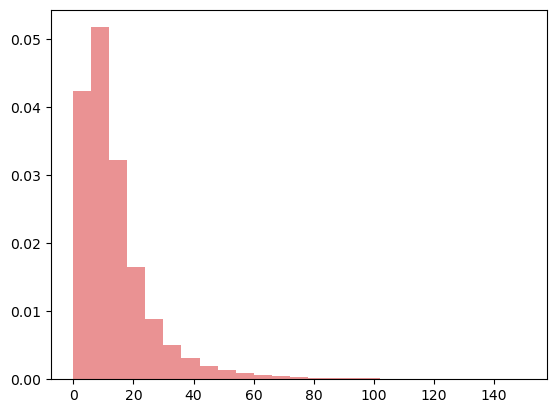

In [87]:
# bins = 5*np.logspace(-1, 2, 50)
bins = np.linspace(0, 150, 26)

window_idx = 0

avg_stationary_stim_SD = np.nanmean(stationary_stim_SD[window_idx, :, :, :, :, :, :], axis=(0, -1))
avg_moving_stim_SD = np.nanmean(moving_stim_SD[window_idx, :, :, :, :, :, :], axis=(0, -1))

# plot the histograms of the stationary and moving stim SD
# plt.hist(stationary_stim_SD[2, :, 6, 0, 3, 4, :].flatten(), bins=bins, alpha=0.5, color='tab:red', label='stationary', density=True)
# plt.hist(moving_stim_SD[2, :, 6, 0, 3, 4, :].flatten(), bins=bins, alpha=0.5, color='tab:blue', label='moving', density=True)

# plt.hist(avg_stationary_stim_SD.flatten(), bins=bins, alpha=0.5, color='tab:red', label='stationary', density=True)
# plt.hist(avg_moving_stim_SD.flatten(), bins=bins, alpha=0.5, color='tab:blue', label='moving', density=True)
plt.hist(stationary_stim_SD.flatten(), bins=bins, alpha=0.5, color='tab:red', label='stationary', density=True)
plt.hist(moving_stim_SD.flatten(), bins=bins, alpha=0.5, color='tab:blue', label='moving', density=True)

# compute the mean
mean_stationary_SD = np.nanmean(avg_stationary_stim_SD)
mean_moving_SD = np.nanmean(avg_moving_stim_SD)

plt.axvline(mean_moving_SD, color='tab:blue', linestyle='dashed', linewidth=1)
plt.axvline(mean_stationary_SD, color='tab:red', linestyle='dashed', linewidth=1)
plt.text(mean_moving_SD, 0.01, f"{mean_moving_SD:.2f}", color='tab:blue')
plt.text(mean_stationary_SD, 0.01, f"{mean_stationary_SD:.2f}", color='tab:red')
plt.yscale('log')
# plt.ylim(0.0001, 0.2)
plt.xlim(0, 150)
# plt.xscale('log')

# save as pdf
plt.savefig(f"../manuscript_figures/fig2_Gabor_SD_dist_full.pdf", bbox_inches='tight', format='pdf')

In [ ]:
stationary_stim_SD.shape

In [ ]:
avg_stationary_stim_SD = np.nanmean(stationary_stim_SD, axis=(1,-1))
avg_moving_stim_SD = np.nanmean(moving_stim_SD, axis=(1, -1))

In [ ]:
windowed_std_moving_responses = avg_moving_stim_SD
windowed_std_stationary_responses = avg_stationary_stim_SD

In [ ]:
ratio_of_SD = avg_moving_stim_SD / avg_stationary_stim_SD

In [ ]:
ratio_of_SD_tau = np.mean(ratio_of_SD, axis=(1, 2, 3, 4))
ratio_of_SD_tau_std = np.std(ratio_of_SD, axis=(1, 2, 3, 4))
tau = [1, 2, 5, 10, 20]

plt.plot(tau, ratio_of_SD_tau, color='tab:orange')
plt.fill_between(tau, ratio_of_SD_tau-ratio_of_SD_tau_std, ratio_of_SD_tau+ratio_of_SD_tau_std, alpha=0.2, color='tab:orange')
plt.axhline(1, color='k', linestyle=':')
plt.xscale('log')
plt.savefig("../manuscript_figures/figure2_ratio_SD_v_tau.pdf", bbox_inches='tight', format='pdf')

### everything else

In [ ]:
import bottleneck as bn

environments = ['field', 'forest', 'orchard', 'tall_grass', 'pond']

stationary_stim_SD = []
moving_stim_SD = []
stationary_stim = []
moving_stim = []
stationary_stim_low_freq_SD = []
moving_stim_low_freq_SD = []
stationary_stim_low_freq = []
moving_stim_low_freq = []
stationary_stim_eye_movements_SD = []
moving_stim_eye_movements_SD = []
stationary_stim_eye_movements = []
moving_stim_eye_movements = []
stationary_stim_eye_movements_long_SD = []
stationary_stim_eye_movements_long = []

fps = 30
window_length = np.array([2, 5, 10]) # seconds
window_length = np.array([5]) # seconds
window_size = window_length * fps
print(window_size)
num_samples = 1740

# get the responses for each environment
for i in range(len(window_size)):
    stationary_stim_SD_temp = []
    moving_stim_SD_temp = []
    stationary_stim_temp = []
    moving_stim_temp = []
    stationary_stim_low_freq_SD_temp = []
    moving_stim_low_freq_SD_temp = []
    stationary_stim_low_freq_temp = []
    moving_stim_low_freq_temp = []
    stationary_stim_eye_movements_SD_temp = []
    moving_stim_eye_movements_SD_temp = []
    stationary_stim_eye_movements_temp = []
    moving_stim_eye_movements_temp = []
    stationary_stim_eye_movements_long_SD_temp = []
    stationary_stim_eye_movements_long_temp = []
    for env_key in environments:
        all_gabor_responses_env = all_gabor_responses[env_key]
        all_gabor_responses_env_low_freq = all_gabor_responses_low_freq[env_key]
        all_gabor_responses_env_eye_movements = all_gabor_responses_eye_movements[env_key]
        all_gabor_responses_env_eye_movements_long = all_gabor_responses_eye_movements_long[env_key]
        print(all_gabor_responses_env.keys())
        for vid_key in all_gabor_responses_env.keys():
            # compute the moving SD
            resp_SD = bn.move_std(all_gabor_responses_env[vid_key][()], window=window_size[i], min_count=window_size[i], axis=-1)[:, :, :, :, :num_samples]
            if 'stationary' in vid_key:
                stationary_stim_SD_temp.append(resp_SD)
                stationary_stim_temp.append(all_gabor_responses_env[vid_key][()])
            if 'moving' in vid_key and 'free_moving' not in vid_key:
                moving_stim_SD_temp.append(resp_SD)
                moving_stim_temp.append(all_gabor_responses_env[vid_key][()])
        for vid_key in all_gabor_responses_env_low_freq.keys():
            # compute the moving SD
            resp_SD = bn.move_std(all_gabor_responses_env_low_freq[vid_key][()], window=window_size[i], min_count=window_size[i], axis=-1)[:, :, :, :, :num_samples]
            if 'stationary' in vid_key:
                stationary_stim_low_freq_SD_temp.append(resp_SD)
                stationary_stim_low_freq_temp.append(all_gabor_responses_env_low_freq[vid_key][()])
            if 'moving' in vid_key and 'free_moving' not in vid_key:
                moving_stim_low_freq_SD_temp.append(resp_SD)
                moving_stim_low_freq_temp.append(all_gabor_responses_env_low_freq[vid_key][()])
        for vid_key in all_gabor_responses_env_eye_movements.keys():
            # compute the moving SD
            resp_SD = bn.move_std(all_gabor_responses_env_eye_movements[vid_key][()], window=window_size[i], min_count=window_size[i], axis=-1)[:, :, :, :, :num_samples]
            if 'stationary' in vid_key:
                stationary_stim_eye_movements_SD_temp.append(resp_SD)
                stationary_stim_eye_movements_temp.append(all_gabor_responses_env_eye_movements[vid_key][()])
            if 'moving' in vid_key and 'free_moving' not in vid_key:
                moving_stim_eye_movements_SD_temp.append(resp_SD)
                moving_stim_eye_movements_temp.append(all_gabor_responses_env_eye_movements[vid_key][()])
        for vid_key in all_gabor_responses_env_eye_movements_long.keys():
            # compute the moving SD
            resp_SD = bn.move_std(all_gabor_responses_env_eye_movements_long[vid_key][()], window=window_size[i], min_count=window_size[i], axis=-1)[:, :, :, :, :num_samples]
            if 'stationary' in vid_key:
                stationary_stim_eye_movements_long_SD_temp.append(resp_SD)
                stationary_stim_eye_movements_long_temp.append(all_gabor_responses_env_eye_movements_long[vid_key][()])
    stationary_stim_SD.append(stationary_stim_SD_temp)
    moving_stim_SD.append(moving_stim_SD_temp)
    stationary_stim.append(stationary_stim_temp)
    moving_stim.append(moving_stim_temp)
    stationary_stim_low_freq_SD.append(stationary_stim_low_freq_SD_temp)
    moving_stim_low_freq_SD.append(moving_stim_low_freq_SD_temp)
    stationary_stim_low_freq.append(stationary_stim_low_freq_temp)
    moving_stim_low_freq.append(moving_stim_low_freq_temp)
    stationary_stim_eye_movements_SD.append(stationary_stim_eye_movements_SD_temp)
    moving_stim_eye_movements_SD.append(moving_stim_eye_movements_SD_temp)
    stationary_stim_eye_movements.append(stationary_stim_eye_movements_temp)
    moving_stim_eye_movements.append(moving_stim_eye_movements_temp)
    stationary_stim_eye_movements_long_SD.append(stationary_stim_eye_movements_long_SD_temp)
    stationary_stim_eye_movements_long.append(stationary_stim_eye_movements_long_temp)

In [ ]:
# convert everything to numpy arrays
stationary_stim_eye_movements_SD = np.array(stationary_stim_eye_movements_SD)
moving_stim_eye_movements_SD = np.array(moving_stim_eye_movements_SD)
stationary_stim_low_freq_SD = np.array(stationary_stim_low_freq_SD)
moving_stim_low_freq_SD = np.array(moving_stim_low_freq_SD)
stationary_stim_SD = np.array(stationary_stim_SD)
moving_stim_SD = np.array(moving_stim_SD)
stationary_stim_eye_movements_long_SD = np.array(stationary_stim_eye_movements_long_SD)

In [ ]:
np.nanmax(stationary_stim_SD)

## Visualization of SDs

In [ ]:
mean_windowed_std_stationary_responses = np.nanmean(stationary_stim_SD, axis=(1, -1))
mean_windowed_std_moving_responses = np.nanmean(moving_stim_SD, axis=(1, -1))
mean_windowed_std_stationary_responses_low_freq = np.nanmean(stationary_stim_low_freq_SD[:, :, :, :, 2:, :, :], axis=(1, -1))
mean_windowed_std_moving_responses_low_freq = np.nanmean(moving_stim_low_freq_SD[:, :, :, :, 2:, :, :], axis=(1, -1))
mean_windowed_std_stationary_responses_eye_movements = np.nanmean(stationary_stim_eye_movements_SD, axis=(1, -1))
mean_windowed_std_moving_responses_eye_movements = np.nanmean(moving_stim_eye_movements_SD, axis=(1, -1))
SD_windowed_std_stationary_responses = np.nanstd(stationary_stim_SD, axis=(1, -1))
SD_windowed_std_moving_responses = np.nanstd(moving_stim_SD, axis=(1, -1))
SD_windowed_std_stationary_responses_low_freq = np.nanstd(stationary_stim_low_freq_SD[:, :, :, :, 2:, :, :], axis=(1, -1))
SD_windowed_std_moving_responses_low_freq = np.nanstd(moving_stim_low_freq_SD[:, :, :, :, 2:, :, :], axis=(1, -1))
SD_windowed_std_stationary_responses_eye_movements = np.nanstd(stationary_stim_eye_movements_SD, axis=(1, -1))
SD_windowed_std_moving_responses_eye_movements = np.nanstd(moving_stim_eye_movements_SD, axis=(1, -1))

In [ ]:
# compute the ratio of the means
mean_ratio_moving_stationary_low_freq = mean_windowed_std_moving_responses_low_freq / mean_windowed_std_stationary_responses_low_freq
mean_ratio_moving_stationary_eye_movements = mean_windowed_std_moving_responses_eye_movements / mean_windowed_std_stationary_responses_eye_movements

In [ ]:
# scatter plot of the mean and std of the responses per filter
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for tau_idx in range(3):
    ax[tau_idx].scatter(mean_windowed_std_stationary_responses_low_freq[tau_idx].flatten(), mean_windowed_std_moving_responses_low_freq[tau_idx].flatten(), s=3, alpha=0.5, color='tab:orange')
    ax[tau_idx].scatter(mean_windowed_std_stationary_responses_eye_movements[tau_idx].flatten(), mean_windowed_std_moving_responses_eye_movements[tau_idx].flatten(), s=3, alpha=0.5, color='tab:purple')
    # do a density scatter plot
    # make the x and y min max the same based on get_xlim and get_ylim
    min_val = np.min([ax[tau_idx].get_xlim()[0], ax[tau_idx].get_ylim()[0]])
    max_val = np.max([ax[tau_idx].get_xlim()[1], ax[tau_idx].get_ylim()[1]])
    ax[tau_idx].set_xlim(min_val, max_val)
    ax[tau_idx].set_ylim(min_val, max_val)
    # create a line for the identity which goes from the minimum to the maximum of the data
    ax[tau_idx].plot([min_val, max_val], [min_val, max_val], 'k--')
    ax[tau_idx].set_title(f'Window size: {window_length[tau_idx]}s')
    ax[tau_idx].set_xlabel('Mean stationary SD')
    ax[tau_idx].set_ylabel('Mean moving SD')

In [ ]:
mean_ratio_moving_stationary_eye_movements.shape

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(8,3), sharey=True)

ax[0].plot(np.linspace(0.03, 0.12, 10), np.mean(mean_ratio_moving_stationary_low_freq, axis=(1, 2, 4)).T)
ax[1].plot(np.linspace(0.03, 0.12, 10), np.mean(mean_ratio_moving_stationary_eye_movements, axis=(1, 2, 4)).T)

In [ ]:
# plot the means in a bar plot
fig, ax = plt.subplots(1, 3, figsize=(12*2, 3*2), sharey=True)
for tau_idx in range(3):
    ax[tau_idx].bar(['no eye movements', 'eye movements'], [np.nanmean(mean_ratio_moving_stationary_low_freq[tau_idx]), np.nanmean(mean_ratio_moving_stationary_eye_movements[tau_idx])], color=['tab:orange', 'tab:purple'])
    ax[tau_idx].set_ylabel('Mean ratio of windowed SD (moving/stationary)')
    ax[tau_idx].set_title('Window length: {}s'.format(window_length[tau_idx]))
    # print the numerical value above the bar
    for i, v in enumerate([np.nanmean(mean_ratio_moving_stationary_low_freq[tau_idx]), np.nanmean(mean_ratio_moving_stationary_eye_movements[tau_idx])]):
        ax[tau_idx].text(i, v, '{:.2f}'.format(v), ha='center', va='bottom')

In [ ]:
mean_windowed_std_stationary_responses = np.nanmean(stationary_stim_SD, axis=(1,2,3,5,6))
mean_windowed_std_moving_responses = np.nanmean(moving_stim_SD, axis=(1,2,3,5,6))
mean_windowed_std_stationary_responses_low_freq = np.nanmean(stationary_stim_low_freq_SD[:, :, :, :, 2:, :, :], axis=(1,2,3,4,5,6))
mean_windowed_std_moving_responses_low_freq = np.nanmean(moving_stim_low_freq_SD[:, :, :, :, 2:, :, :], axis=(1,2,3,4,5,6))
mean_windowed_std_stationary_responses_eye_movements = np.nanmean(stationary_stim_eye_movements_SD, axis=(1,2,3,4,5,6))
mean_windowed_std_moving_responses_eye_movements = np.nanmean(moving_stim_eye_movements_SD, axis=(1,2,3,4,5,6))
mean_windowed_std_stationary_responses_eye_movements_long = np.nanmean(stationary_stim_eye_movements_long_SD, axis=(1,2,3,4,5,6))
# SD_windowed_std_stationary_responses = np.nanstd(stationary_stim_SD, axis=(1,2,3,5,6))
# SD_windowed_std_moving_responses = np.nanstd(moving_stim_SD, axis=(1,2,3,5,6))
# SD_windowed_std_stationary_responses_low_freq = np.nanstd(stationary_stim_low_freq_SD[:, :, :, :, 2:, :, :], axis=(1,2,3,4,5,6))
# SD_windowed_std_moving_responses_low_freq = np.nanstd(moving_stim_low_freq_SD[:, :, :, :, 2:, :, :], axis=(1,2,3,4,5,6))
# SD_windowed_std_stationary_responses_eye_movements = np.nanstd(stationary_stim_eye_movements_SD, axis=(1,2,3,4,5,6))
# SD_windowed_std_moving_responses_eye_movements = np.nanstd(moving_stim_eye_movements_SD, axis=(1,2,3,4,5,6))
# # compute the standard error
# SE_windowed_std_stationary_responses = SD_windowed_std_stationary_responses / np.sqrt(stationary_stim_SD.shape[1])
# SE_windowed_std_moving_responses = SD_windowed_std_moving_responses / np.sqrt(moving_stim_SD.shape[1])
# SE_windowed_std_stationary_responses_low_freq = SD_windowed_std_stationary_responses_low_freq / np.sqrt(stationary_stim_low_freq_SD.shape[1])
# SE_windowed_std_moving_responses_low_freq = SD_windowed_std_moving_responses_low_freq / np.sqrt(moving_stim_low_freq_SD.shape[1])
# SE_windowed_std_stationary_responses_eye_movements = SD_windowed_std_stationary_responses_eye_movements / np.sqrt(stationary_stim_eye_movements_SD.shape[1])
# SE_windowed_std_moving_responses_eye_movements = SD_windowed_std_moving_responses_eye_movements / np.sqrt(moving_stim_eye_movements_SD.shape[1])

In [ ]:
bins = 2*np.logspace(-1, 2, 100)

plt.hist(stationary_stim_low_freq_SD[:, :, :, 2:, :, :].flatten(), bins=bins, color='tab:red', alpha=0.5)
plt.hist(stationary_stim_eye_movements_SD[:, :, :, :, :, :].flatten(), bins=bins, color='tab:orange', alpha=0.5)
plt.hist(moving_stim_low_freq_SD[:, :, :, 2:, :, :].flatten(), bins=bins, color='tab:blue', alpha=0.5)
plt.hist(moving_stim_eye_movements_SD[:, :, :, :, :, :].flatten(), bins=bins, color='tab:purple', alpha=0.5)
plt.xscale('log')

In [ ]:
# plot the means in a bar plot
fig, ax = plt.subplots(1, 3, figsize=(12*2, 3*2))
for tau_idx in range(3):
    ax[tau_idx].bar(['stationary', 'moving'], [mean_windowed_std_stationary_responses_low_freq[tau_idx], mean_windowed_std_moving_responses_low_freq[tau_idx]], color=['tab:red', 'tab:blue'])
    ax[tau_idx].set_ylabel('Mean of windowed SD')
    ax[tau_idx].set_title('Window length: {}s'.format(window_length[tau_idx]))
    # set the y tick to be from zero to the closest integer above the maximum value
    # ax[tau_idx].set_yticks(np.linspace(0, np.ceil(np.max([mean_windowed_std_stationary_responses_low_freq[tau_idx], mean_windowed_std_moving_responses_low_freq[tau_idx]])), 3))
    ax[tau_idx].set_yticks(np.linspace(0, 50, 3))
    # print the numerical value above the bar
    for i, v in enumerate([mean_windowed_std_stationary_responses_low_freq[tau_idx], mean_windowed_std_moving_responses_low_freq[tau_idx]]):
        ax[tau_idx].text(i, v, '{:.2f}'.format(v), ha='center', va='bottom')
# save as svg
plt.savefig('../cosyne_2025_figures/mean_windowed_SD_low_freq.svg', format='svg')

In [ ]:
# plot the means in a bar plot
fig, ax = plt.subplots(1, 3, figsize=(12*2, 3*2))
for tau_idx in range(3):
    ax[tau_idx].bar(['stationary', 'moving'], [mean_windowed_std_stationary_responses_eye_movements_long[tau_idx], mean_windowed_std_moving_responses_eye_movements[tau_idx]], color=['tab:red', 'tab:blue'])
    ax[tau_idx].set_ylabel('Mean of windowed SD')
    ax[tau_idx].set_title('Window length: {}s'.format(window_length[tau_idx]))
    # set the y tick to be from zero to the closest integer above the maximum value
    # ax[tau_idx].set_yticks(np.linspace(0, np.ceil(np.max([mean_windowed_std_stationary_responses_low_freq[tau_idx], mean_windowed_std_moving_responses_low_freq[tau_idx]])), 3))
    ax[tau_idx].set_yticks(np.linspace(0, 50, 3))
    # print the numerical value above the bar
    for i, v in enumerate([mean_windowed_std_stationary_responses_eye_movements_long[tau_idx], mean_windowed_std_moving_responses_eye_movements[tau_idx]]):
        ax[tau_idx].text(i, v, '{:.2f}'.format(v), ha='center', va='bottom')
# save as svg
plt.savefig('../cosyne_2025_figures/mean_windowed_SD_low_freq_eye_movements.svg', format='svg')

In [ ]:
# plot the means in a bar plot
fig, ax = plt.subplots(1, 3, figsize=(12*2, 3*2), sharey=True)
for tau_idx in range(3):
    ax[tau_idx].bar(['stationary', 'stationary\neye movement', 'moving', 'moving\neye movement'], [mean_windowed_std_stationary_responses_low_freq[tau_idx], mean_windowed_std_stationary_responses_eye_movements[tau_idx], mean_windowed_std_moving_responses_low_freq[tau_idx], mean_windowed_std_moving_responses_eye_movements[tau_idx]], color=['tab:red', 'tab:orange', 'tab:blue', 'tab:purple'])
    ax[tau_idx].set_ylabel('Mean windowed SD')
    ax[tau_idx].set_title('Window length: {}s'.format(window_length[tau_idx]))
    # print the numerical value above the bar
    for i, v in enumerate([mean_windowed_std_stationary_responses_low_freq[tau_idx], mean_windowed_std_stationary_responses_eye_movements[tau_idx], mean_windowed_std_moving_responses_low_freq[tau_idx], mean_windowed_std_moving_responses_eye_movements[tau_idx]]):
        ax[tau_idx].text(i, v, "{:.2f}".format(v), ha='center')


In [ ]:
# plot the means in a bar plot
fig, ax = plt.subplots(1, 3, figsize=(12*2, 3*2), sharey=True)
for tau_idx in range(3):
    stationary_eye_movement_ratio = mean_windowed_std_stationary_responses_eye_movements[tau_idx] / mean_windowed_std_stationary_responses_low_freq[tau_idx]
    moving_eye_movement_ratio = mean_windowed_std_moving_responses_eye_movements[tau_idx] / mean_windowed_std_stationary_responses_low_freq[tau_idx]
    moving_ratio = mean_windowed_std_moving_responses_low_freq[tau_idx] / mean_windowed_std_stationary_responses_low_freq[tau_idx]
    ax[tau_idx].bar(['stationary', 'stationary\neye movement', 'moving', 'moving\neye movement'], [1, stationary_eye_movement_ratio, moving_ratio, moving_eye_movement_ratio], color=['tab:red', 'tab:orange', 'tab:blue', 'tab:purple'])
    ax[tau_idx].set_ylabel('Mean windowed SD ratio')
    ax[tau_idx].set_title('Window length: {}s'.format(window_length[tau_idx]))
    # print the numerical value above the bar
    for i, v in enumerate([1, stationary_eye_movement_ratio, moving_ratio, moving_eye_movement_ratio]):
        ax[tau_idx].text(i, v, "{:.2f}".format(v), ha='center')

### Without eye movements

In [ ]:
moving_stim_SD.shape

In [ ]:
tau_idx = 0
windowed_std_moving_responses = np.nanmean(moving_stim_SD[tau_idx], axis=(0, -1))
windowed_std_stationary_responses = np.nanmean(stationary_stim_SD[tau_idx], axis=(0, -1))
# windowed_std_moving_responses_low_freq = np.nanmean(moving_stim_low_freq_SD[tau_idx], axis=(0, -1))
# windowed_std_stationary_responses_low_freq = np.nanmean(stationary_stim_low_freq_SD[tau_idx], axis=(0, -1))

In [ ]:
print('Stationary stim SD min: ', np.nanmin(windowed_std_stationary_responses))
print('Stationary stim SD max: ', np.nanmax(windowed_std_stationary_responses))
print('Moving stim SD min: ', np.nanmin(windowed_std_moving_responses))
print('Moving stim SD max: ', np.nanmax(windowed_std_moving_responses))

In [ ]:
rel_var = windowed_std_moving_responses/windowed_std_stationary_responses
rel_var_low_freq = windowed_std_moving_responses_low_freq/windowed_std_stationary_responses_low_freq
diff_var = windowed_std_moving_responses - windowed_std_stationary_responses
diff_var_low_freq = windowed_std_moving_responses_low_freq - windowed_std_stationary_responses_low_freq

rel_var_per_freq = np.mean(rel_var, axis=(0,1,3))
std_rel_var_per_freq = np.std(rel_var, axis=(0,1,3))
rel_var_low_freq_per_freq = np.mean(rel_var_low_freq, axis=(0,1,3))
std_rel_var_low_freq_per_freq = np.std(rel_var_low_freq, axis=(0,1,3))
diff_var_per_freq = np.mean(diff_var, axis=(0,1,3))
std_diff_var_per_freq = np.std(diff_var, axis=(0,1,3))
diff_var_low_freq_per_freq = np.mean(diff_var_low_freq, axis=(0,1,3))
std_diff_var_low_freq_per_freq = np.std(diff_var_low_freq, axis=(0,1,3))

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].plot(freq_arr, rel_var_per_freq)
ax[0].fill_between(freq_arr, rel_var_per_freq - std_rel_var_per_freq, rel_var_per_freq + std_rel_var_per_freq, alpha=0.5)
ax[0].set_xscale('log')
ax[0].set_xlabel('Spatial frequency (cycles/degree)')
ax[0].set_ylabel('Relative variance')

ax[1].plot(freq_arr, diff_var_per_freq)
ax[1].fill_between(freq_arr, diff_var_per_freq - std_diff_var_per_freq, diff_var_per_freq + std_diff_var_per_freq, alpha=0.5)
ax[1].set_xscale('log')
ax[1].set_xlabel('Spatial frequency (cycles/degree)')
ax[1].set_ylabel('Difference in variance')
ax[1].bar([0, 1], [avg_diff_var_low_freq, avg_diff_var_high_freq], color=['tab:blue', 'tab:red'], width=0.5)
plt.savefig('../cosyne_2025_figures/variance_ratio_and_diff.svg', format='svg')

In [ ]:
diff_var_per_freq.shape

In [ ]:
low_freq_prob.shape

In [ ]:
marm_perif_prob.shape

In [ ]:
diff_var_low_freq = diff_var_per_freq[low_spatial_freq_idx]
diff_var_high_freq = diff_var_per_freq[high_spatial_freq_idx]

In [ ]:
# take the weighted average
avg_diff_var_low_freq = np.sum(diff_var_low_freq * low_freq_prob, axis=0)
avg_diff_var_high_freq = np.sum(diff_var_high_freq * high_freq_prob, axis=0)
avg_diff_var_marm_perif = np.sum(diff_var_per_freq * marm_perif_prob, axis=0)

In [ ]:
avg_diff_var_low_freq

In [ ]:
avg_diff_var_marm_perif

In [ ]:
avg_diff_var_high_freq

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].plot(freq_arr_low_freq, rel_var_low_freq_per_freq)
ax[0].fill_between(freq_arr_low_freq, rel_var_low_freq_per_freq - std_rel_var_low_freq_per_freq, rel_var_low_freq_per_freq + std_rel_var_low_freq_per_freq, alpha=0.5)
ax[0].set_xscale('log')
ax[0].set_xlabel('Spatial frequency (cycles/degree)')
ax[0].set_ylabel('Relative variance')

ax[1].plot(freq_arr_low_freq, diff_var_low_freq_per_freq)
ax[1].fill_between(freq_arr_low_freq, diff_var_low_freq_per_freq - std_diff_var_low_freq_per_freq, diff_var_low_freq_per_freq + std_diff_var_low_freq_per_freq, alpha=0.5)
ax[1].set_xscale('log')
ax[1].set_xlabel('Spatial frequency (cycles/degree)')
ax[1].set_ylabel('Difference in variance')

## Gaussian optimization

In [ ]:
# optimize nonlinearities using lookup table
dir_name = 'gaussian_optimization_analytic_fast' # 'test_gaussian_optimization_kraskov' # 'test_gaussian_optimization_fast_response_entropy' # 'redo_all_sigma_even_more_bins_optimized_zscored_data' # 'all_sigma_more_bins_zscored_data' # 'redo_all_sigma_less_bins_optimized_zscored_data' # 'redo_all_sigma_more_bins_optimized_zscored_data' # 'all_sigma_more_bins_optimized_zscored_data'  # 'higher_sigma_for_zscored_data' # 'more_sigma_bins_gaussian_results' # 'even_more_sigma_bins_gaussian_results'

MI_arr = np.load(dir_name + '/MI_arr.npy')
# stimulus_entropy = np.load(dir_name + '/stimulus_entropy.npy')
average_response_arr = np.load(dir_name + '/average_response_arr.npy')
stimulus_entropy = np.load(dir_name + '/stim_entropy_arr.npy')

# stimulus_bins = np.load(dir_name + '/stimulus_bins.npy') # np.linspace(-30, 30, 200)
response_bins = np.load(dir_name + '/response_bins.npy') #

# Define the range of k and L values for grid search
k_arr = np.load(dir_name + '/k_arr.npy') # np.logspace(-2, 2, num_bins) # 5*np.logspace(-2, 0, 100)
L_arr = np.load(dir_name + '/L_arr.npy') # np.arange(0.02, 4.02, .02) # np.arange(0.05, 5.05, .05)
sigma_arr = np.load(dir_name + '/sigma_arr.npy') # 5*np.logspace(-2, 1, num_bins) # np.logspace(-2, 2, num_bins)

# for each sigma compute the optimal parameters for a range of different lambdas
lambda_arr = np.arange(0, 10.5, .5)
optimal_k = np.zeros((len(sigma_arr), len(lambda_arr)))
optimal_L = np.zeros((len(sigma_arr), len(lambda_arr)))
optimal_k_idx = np.zeros((len(sigma_arr), len(lambda_arr)), dtype=np.int32)
optimal_L_idx = np.zeros((len(sigma_arr), len(lambda_arr)), dtype=np.int32)

# def calc_Gauss_entropy(sigma):
#     return (0.5 * np.log(2 * np.pi * np.e * sigma**2) + 0.5)/np.log(2)

# calculate the entropy of the Gaussian distribution
# gauss_entropy = calc_Gauss_entropy(sigma_arr)

# normalize the mutual information by the entropy of the Gaussian distribution
# MI_arr = MI_arr / gauss_entropy[:, np.newaxis, np.newaxis]

# import gaussian filter to involve
from scipy.ndimage import gaussian_filter

for i, lambda_ in enumerate(lambda_arr):
    utility = MI_arr - lambda_ * average_response_arr # np.clip(MI_arr/stimulus_entropy[:, np.newaxis, np.newaxis], 0, 1) - lambda_ * average_response_arr
    print(utility.shape)
    # utility = gaussian_filter(utility, sigma=5, axes=(1, 2))
    for j, sigma in enumerate(sigma_arr):
        optimal_k_idx[j, i] = int(np.unravel_index(np.argmax(utility[j, :, :]), utility[j, :, :].shape)[0])
        optimal_L_idx[j, i] = int(np.unravel_index(np.argmax(utility[j, :, :]), utility[j, :, :].shape)[1])
        optimal_k[j, i] = k_arr[optimal_k_idx[j, i]]
        optimal_L[j, i] = L_arr[optimal_L_idx[j, i]]
        

In [ ]:
lambda_

In [ ]:
closest_sigma_idx_mov = np.argmin(np.abs(sigma_arr - mean_moving_SD))
closest_sigma_idx_stat = np.argmin(np.abs(sigma_arr - mean_stationary_SD))

In [ ]:
np.save(dir_name + '/lambda_arr.npy', lambda_arr)
np.save(dir_name + '/optimal_k.npy', optimal_k)
np.save(dir_name + '/optimal_L.npy', optimal_L)
np.save(dir_name + '/optimal_k_idx.npy', optimal_k_idx)
np.save(dir_name + '/optimal_L_idx.npy', optimal_L_idx)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# load the necessary arrays for the utility landscape calculation
dir_name = 'gaussian_optimization_analytic_fast'
MI_arr = np.load(dir_name + '/MI_arr.npy')
average_response_arr = np.load(dir_name + '/average_response_arr.npy')
k_arr = np.load(dir_name + '/k_arr.npy')
L_arr = np.load(dir_name + '/L_arr.npy')
sigma_arr = np.load(dir_name + '/sigma_arr.npy') 
lambda_arr = np.load(dir_name + '/lambda_arr.npy')
optimal_k = np.load(dir_name + '/optimal_k.npy')
optimal_L = np.load(dir_name + '/optimal_L.npy')
optimal_k_idx = np.load(dir_name + '/optimal_k_idx.npy')
optimal_L_idx = np.load(dir_name + '/optimal_L_idx.npy')

fig, ax = plt.subplots(2, 4, figsize=(16, 10), width_ratios=[5, 5, 5, 1])

lambda_idx = 10
lambda_ = lambda_arr[lambda_idx]
utility = MI_arr - lambda_ * average_response_arr
min_k = 90
max_k = 120
max_L = 15
closest_sigma_idx_stat = 158 # precomputed based on SD of a specific filter
closest_sigma_idx_mov = 185 # precomputed based on SD of a specific filter

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap
cmap_name = 'Blues'
cmap = plt.get_cmap(cmap_name)
min_colormap_val = 0
max_colormap_val = 0.5
new_cmap = truncate_colormap(cmap, min_colormap_val, max_colormap_val)

MI_max = np.max(MI_arr[closest_sigma_idx_mov, min_k:max_k, :max_L])
MI_min = np.min(MI_arr[closest_sigma_idx_mov, min_k:max_k, :max_L])
MI_norm = mcolors.Normalize(vmin=MI_min, vmax=MI_max)
response_max = np.max(average_response_arr[closest_sigma_idx_mov, min_k:max_k, :max_L])
response_min = np.min(average_response_arr[closest_sigma_idx_mov, min_k:max_k, :max_L])
response_norm = mcolors.Normalize(vmin=response_min, vmax=response_max)
utility_max = np.max(utility[closest_sigma_idx_mov, min_k:max_k, :max_L])
utility_min = np.min(utility[closest_sigma_idx_mov, min_k:max_k, :max_L])
utility_norm = mcolors.Normalize(vmin=utility_min, vmax=utility_max)

MI_max = np.max(MI_arr[closest_sigma_idx_stat, min_k:max_k, :max_L])
MI_min = np.min(MI_arr[closest_sigma_idx_stat, min_k:max_k, :max_L])
MI_norm_stat = mcolors.Normalize(vmin=MI_min, vmax=MI_max)
response_max = np.max(average_response_arr[closest_sigma_idx_stat, min_k:max_k, :max_L])
response_min = np.min(average_response_arr[closest_sigma_idx_stat, min_k:max_k, :max_L])
response_norm_stat = mcolors.Normalize(vmin=response_min, vmax=response_max)
utility_max = np.max(utility[closest_sigma_idx_stat, min_k:max_k, :max_L])
utility_min = np.min(utility[closest_sigma_idx_stat, min_k:max_k, :max_L])
utility_norm_stat = mcolors.Normalize(vmin=utility_min, vmax=utility_max)


ax[0, 0].imshow(MI_arr[closest_sigma_idx_stat, min_k:max_k, :max_L].T, origin='lower', aspect='auto', interpolation='None', cmap=new_cmap, norm=MI_norm_stat)
ax[1, 0].imshow(MI_arr[closest_sigma_idx_mov, min_k:max_k, :max_L].T, origin='lower', aspect='auto', interpolation='None', cmap=new_cmap, norm=MI_norm)
im = ax[0, 1].imshow(average_response_arr[closest_sigma_idx_stat, min_k:max_k, :max_L].T, origin='lower', aspect='auto', interpolation='None', cmap=new_cmap, norm=response_norm_stat)
ax[1, 1].imshow(average_response_arr[closest_sigma_idx_mov, min_k:max_k, :max_L].T, origin='lower', aspect='auto', interpolation='None', cmap=new_cmap, norm=response_norm)
ax[0, 2].imshow(utility[closest_sigma_idx_stat, min_k:max_k, :max_L].T, origin='lower', aspect='auto', interpolation='None', cmap=new_cmap, norm=utility_norm_stat)
ax[1, 2].imshow(utility[closest_sigma_idx_mov, min_k:max_k, :max_L].T, origin='lower', aspect='auto', interpolation='None', cmap=new_cmap, norm=utility_norm)
ax[0, 0].scatter(optimal_k_idx[closest_sigma_idx_stat, lambda_idx]-min_k, optimal_L_idx[closest_sigma_idx_stat, lambda_idx], color='tab:gray')
ax[1, 0].scatter(optimal_k_idx[closest_sigma_idx_mov, lambda_idx]-min_k, optimal_L_idx[closest_sigma_idx_mov, lambda_idx], color='tab:orange')
ax[0, 1].scatter(optimal_k_idx[closest_sigma_idx_stat, lambda_idx]-min_k, optimal_L_idx[closest_sigma_idx_stat, lambda_idx], color='tab:gray')
ax[1, 1].scatter(optimal_k_idx[closest_sigma_idx_mov, lambda_idx]-min_k, optimal_L_idx[closest_sigma_idx_mov, lambda_idx], color='tab:orange')
ax[0, 2].scatter(optimal_k_idx[closest_sigma_idx_stat, lambda_idx]-min_k, optimal_L_idx[closest_sigma_idx_stat, lambda_idx], color='tab:gray')
ax[1, 2].scatter(optimal_k_idx[closest_sigma_idx_mov, lambda_idx]-min_k, optimal_L_idx[closest_sigma_idx_mov, lambda_idx], color='tab:orange')
for axis in ax.flatten():
    axis.set_xticks([0, max_k-min_k-1], labels=[np.round(k_arr[min_k], 2), np.round(k_arr[max_k-1], 2)])
    axis.set_yticks([0, max_L-1], labels=[L_arr[0], np.round(L_arr[max_L-1], 2)])

fig.colorbar(im, ax=ax[0, 3])

# plt.savefig(f'../manuscript_figures/fig2_utility_cmap_{cmap_name}_ori_{ori_idx}_phase_{phase_idx}_freq_{freq_idx}_pos_{pos_idx}.pdf', bbox_inches='tight', format='pdf')

In [ ]:
# plot the optimal nonlinearities
stim = np.linspace(-250, 250, 100)

plt.plot(stim, optimal_L[closest_sigma_idx_stat, lambda_idx]/(1+np.exp(-optimal_k[closest_sigma_idx_stat, lambda_idx]*stim)), color='gray')
plt.plot(stim, optimal_L[closest_sigma_idx_mov, lambda_idx]/(1+np.exp(-optimal_k[closest_sigma_idx_mov, lambda_idx]*stim)), color='tab:orange')
plt.savefig(f'../manuscript_figures/fig2_optimal_nonlinearity_ori_{ori_idx}_phase_{phase_idx}_freq_{freq_idx}_pos_{pos_idx}.pdf', bbox_inches='tight', format='pdf')

In [ ]:
utility = MI_arr - .25 * average_response_arr # np.clip(MI_arr/stimulus_entropy[:, np.newaxis, np.newaxis], 0, 1) - .01 * average_response_arr
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
# utility = gaussian_filter(utility, sigma=5, axes=(1, 2))
im = ax[0].imshow(utility[10, :, :].T, aspect='auto', origin='lower', cmap='jet')
ax[0].set_xlabel('k')
ax[0].set_ylabel('L')
fig.colorbar(im, ax=ax[0])
im = ax[1].imshow(utility[-1, :, :].T, aspect='auto', origin='lower', cmap='jet')
ax[1].set_xlabel('k')
ax[1].set_ylabel('L')
fig.colorbar(im, ax=ax[1])
# remove x and y ticks
for a in ax:
    a.set_xticks([])
    a.set_yticks([])

In [ ]:
# plt.plot(low_var_sigma_arr, low_var_optimal_L[:, 1], label='k')
plt.plot(sigma_arr, optimal_L[:, 1:], label='k')
plt.xlabel('SD of Gaussian')
plt.ylabel('Optimal L')
plt.xscale('log')
# plt.ylim(0,2)
# plt.xlim(.01, 10)
# plt.plot(low_var_optimal_k[:, 1], label='k')

In [ ]:
np.arange(.02, 10.02, .02).shape

In [ ]:
# plt.plot(low_var_sigma_arr, low_var_optimal_k[:, 2], label='k')
plt.plot(sigma_arr, optimal_k[:, 1:], label='k')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('SD of Gaussian')
plt.ylabel('Optimal k')
# plt.plot(low_var_optimal_k[:, 1], label='k')

In [ ]:
# loop over all orientations and phases and wavelengths and compute the optimal parameters for each
optimal_k_arr_moving = np.zeros((len(orientation_arr), len(phase_arr), len(wavelength_arr[:31]), len(position_arr), len(lambda_arr)))
optimal_L_arr_moving = np.zeros((len(orientation_arr), len(phase_arr), len(wavelength_arr[:31]), len(position_arr), len(lambda_arr)))
optimal_k_arr_stationary = np.zeros((len(orientation_arr), len(phase_arr), len(wavelength_arr[:31]), len(position_arr), len(lambda_arr)))
optimal_L_arr_stationary = np.zeros((len(orientation_arr), len(phase_arr), len(wavelength_arr[:31]), len(position_arr), len(lambda_arr)))
# optimal_k_arr_moving_low_freq = np.zeros((len(orientation_arr), len(phase_arr), len(wavelength_arr_low_freq), len(position_arr), len(lambda_arr)))
# optimal_L_arr_moving_low_freq = np.zeros((len(orientation_arr), len(phase_arr), len(wavelength_arr_low_freq), len(position_arr), len(lambda_arr)))
# optimal_k_arr_stationary_low_freq = np.zeros((len(orientation_arr), len(phase_arr), len(wavelength_arr_low_freq), len(position_arr), len(lambda_arr)))
# optimal_L_arr_stationary_low_freq = np.zeros((len(orientation_arr), len(phase_arr), len(wavelength_arr_low_freq), len(position_arr), len(lambda_arr)))

for i, orientation in tqdm(enumerate(orientation_arr)):
    print("orientation: " + str(orientation))
    for j, phase in enumerate(phase_arr):
        for l, wavelength in enumerate(wavelength_arr[:31]):
            for m, position in enumerate(position_arr):
                # test_moving_std = np.nanmean(windowed_std_moving_responses[i, j, l, m, :], axis=-1)
                # test_stationary_std = np.nanmean(windowed_std_stationary_responses[i, j, l, m, :], axis=-1)
                test_moving_std = windowed_std_moving_responses[2, i, j, l, m]
                test_stationary_std = windowed_std_stationary_responses[2, i, j, l, m]
                for n, lambda_ in enumerate(lambda_arr):
                    moving_idx = np.argmin(np.abs(sigma_arr - test_moving_std))
                    optimal_k_arr_moving[i, j, l, m, n] = optimal_k[moving_idx, n]
                    optimal_L_arr_moving[i, j, l, m, n] = optimal_L[moving_idx, n]
                    stationary_idx = np.argmin(np.abs(sigma_arr - test_stationary_std))
                    optimal_k_arr_stationary[i, j, l, m, n] = optimal_k[stationary_idx, n]
                    optimal_L_arr_stationary[i, j, l, m, n] = optimal_L[stationary_idx, n]
# for i, orientation in tqdm(enumerate(orientation_arr)):
#     print("orientation: " + str(orientation))
#     for j, phase in enumerate(phase_arr):
#         for l, wavelength in enumerate(wavelength_arr_low_freq[2:]):
#             for m, position in enumerate(position_arr):
#                 test_moving_std_low_freq = windowed_std_moving_responses_low_freq[i, j, l, m]
#                 test_stationary_std_low_freq = windowed_std_stationary_responses_low_freq[i, j, l, m]
#                 for n, lambda_ in enumerate(lambda_arr):
#                     moving_idx_low_freq = np.argmin(np.abs(sigma_arr - test_moving_std_low_freq))
#                     stationary_idx_low_freq = np.argmin(np.abs(sigma_arr - test_stationary_std_low_freq))
#                     optimal_k_arr_moving_low_freq[i, j, l, m, n] = optimal_k[moving_idx_low_freq, n]
#                     optimal_L_arr_moving_low_freq[i, j, l, m, n] = optimal_L[moving_idx_low_freq, n]
#                     optimal_k_arr_stationary_low_freq[i, j, l, m, n] = optimal_k[stationary_idx_low_freq, n]
#                     optimal_L_arr_stationary_low_freq[i, j, l, m, n] = optimal_L[stationary_idx_low_freq, n]


In [ ]:
windowed_std_moving_responses.shape

In [ ]:
# loop over all orientations and phases and wavelengths and compute the optimal parameters for each
optimal_k_arr_moving = np.zeros((len(orientation_arr), len(phase_arr), len(wavelength_arr), len(position_arr), len(lambda_arr)))
optimal_L_arr_moving = np.zeros((len(orientation_arr), len(phase_arr), len(wavelength_arr), len(position_arr), len(lambda_arr)))
optimal_k_arr_stationary = np.zeros((len(orientation_arr), len(phase_arr), len(wavelength_arr), len(position_arr), len(lambda_arr)))
optimal_L_arr_stationary = np.zeros((len(orientation_arr), len(phase_arr), len(wavelength_arr), len(position_arr), len(lambda_arr)))

for i, orientation in tqdm(enumerate(orientation_arr)):
    print("orientation: " + str(orientation))
    for j, phase in enumerate(phase_arr):
        for l, wavelength in enumerate(wavelength_arr):
            for m, position in enumerate(position_arr):
                test_moving_std = windowed_std_moving_responses[0, i, j, l, m]
                test_stationary_std = windowed_std_stationary_responses[0, i, j, l, m]
                for n, lambda_ in enumerate(lambda_arr):
                    moving_idx = np.argmin(np.abs(sigma_arr - test_moving_std))
                    optimal_k_arr_moving[i, j, l, m, n] = optimal_k[moving_idx, n]
                    optimal_L_arr_moving[i, j, l, m, n] = optimal_L[moving_idx, n]
                    stationary_idx = np.argmin(np.abs(sigma_arr - test_stationary_std))
                    optimal_k_arr_stationary[i, j, l, m, n] = optimal_k[stationary_idx, n]
                    optimal_L_arr_stationary[i, j, l, m, n] = optimal_L[stationary_idx, n]


In [ ]:
window_length_save = 5
np.save('avg_sd_optimal_k_arr_moving_window_length_' + str(window_length_save) + '.npy', optimal_k_arr_moving)
np.save('avg_sd_optimal_L_arr_moving_window_length_' + str(window_length_save) + '.npy', optimal_L_arr_moving)
np.save('avg_sd_optimal_k_arr_stationary_window_length_' + str(window_length_save) + '.npy', optimal_k_arr_stationary)
np.save('avg_sd_optimal_L_arr_stationary_window_length_' + str(window_length_save) + '.npy', optimal_L_arr_stationary)

In [ ]:
optimal_k_arr_moving = np.load('avg_sd_optimal_k_arr_moving_window_length_' + str(window_length) + '.npy')
optimal_L_arr_moving = np.load('avg_sd_optimal_L_arr_moving_window_length_' + str(window_length) + '.npy')
optimal_k_arr_stationary = np.load('avg_sd_optimal_k_arr_stationary_window_length_' + str(window_length) + '.npy')
optimal_L_arr_stationary = np.load('avg_sd_optimal_L_arr_stationary_window_length_' + str(window_length) + '.npy')

In [ ]:
ratio_L = optimal_L_arr_moving/optimal_L_arr_stationary
ratio_k = optimal_k_arr_moving/optimal_k_arr_stationary

In [ ]:
mean_ratio_L_v_lambda = np.nanmean(ratio_L, axis=(0, 1, 2, 3))
mean_ratio_k_v_lambda = np.nanmean(ratio_k, axis=(0, 1, 2, 3))
std_ratio_L_v_lambda = np.nanstd(ratio_L, axis=(0, 1, 2, 3))
std_ratio_k_v_lambda = np.nanstd(ratio_k, axis=(0, 1, 2, 3))

fig, ax = plt.subplots(1, 3, figsize=(12,3))

# ax2 = ax[2].twinx()

ax[2].plot(lambda_arr[1:], mean_ratio_L_v_lambda[1:], color='tab:orange')
ax[2].fill_between(lambda_arr[1:], mean_ratio_L_v_lambda[1:]-std_ratio_L_v_lambda[1:], mean_ratio_L_v_lambda[1:]+std_ratio_L_v_lambda[1:], alpha=0.2, color='tab:orange')
ax[2].plot(lambda_arr[1:], mean_ratio_k_v_lambda[1:], color='tab:gray')
ax[2].fill_between(lambda_arr[1:], mean_ratio_k_v_lambda[1:]-std_ratio_k_v_lambda[1:], mean_ratio_k_v_lambda[1:]+std_ratio_k_v_lambda[1:], alpha=0.2, color='tab:gray')
ax[2].axhline(1, color='k', linestyle=':')
ax[0].plot(lambda_arr[1:], mean_ratio_L_v_lambda[1:], color='tab:orange')
ax[0].fill_between(lambda_arr[1:], mean_ratio_L_v_lambda[1:]-std_ratio_L_v_lambda[1:], mean_ratio_L_v_lambda[1:]+std_ratio_L_v_lambda[1:], alpha=0.2, color='tab:orange')
ax[1].plot(lambda_arr[1:], mean_ratio_k_v_lambda[1:], color='tab:gray')
ax[1].fill_between(lambda_arr[1:], mean_ratio_k_v_lambda[1:]-std_ratio_k_v_lambda[1:], mean_ratio_k_v_lambda[1:]+std_ratio_k_v_lambda[1:], alpha=0.2, color='tab:gray')

plt.savefig('../manuscript_figures/fig2_L_k_lambda.pdf', bbox_inches='tight', format='pdf')

# Example Gabors

In [ ]:
# low_freq_example
orientation_idx = 0
phase_idx = 0
position_idx = 7
lambda_idx = 2

fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(1, 2, 1)

freq_idx = 2

low_freq_optimal_k_arr_stationary_example = optimal_k_arr_stationary[orientation_idx, phase_idx, freq_idx, position_idx, lambda_idx]
low_freq_optimal_L_arr_stationary_example = optimal_L_arr_stationary[orientation_idx, phase_idx, freq_idx, position_idx, lambda_idx]
low_freq_optimal_k_arr_moving_example = optimal_k_arr_moving[orientation_idx, phase_idx, freq_idx, position_idx, lambda_idx]
low_freq_optimal_L_arr_moving_example = optimal_L_arr_moving[orientation_idx, phase_idx, freq_idx, position_idx, lambda_idx]

freq_idx = -1

high_freq_optimal_k_arr_stationary_example = optimal_k_arr_stationary[orientation_idx, phase_idx, freq_idx, position_idx, lambda_idx]
high_freq_optimal_L_arr_stationary_example = optimal_L_arr_stationary[orientation_idx, phase_idx, freq_idx, position_idx, lambda_idx]
high_freq_optimal_k_arr_moving_example = optimal_k_arr_moving[orientation_idx, phase_idx, freq_idx, position_idx, lambda_idx]
high_freq_optimal_L_arr_moving_example = optimal_L_arr_moving[orientation_idx, phase_idx, freq_idx, position_idx, lambda_idx]

low_freq_stim = np.linspace(-30, 30, 1000)

low_freq_norm_factor = np.max([low_freq_optimal_L_arr_stationary_example, low_freq_optimal_L_arr_moving_example])
high_freq_norm_factor = 1# np.max([high_freq_optimal_L_arr_stationary_example, high_freq_optimal_L_arr_moving_example])

print(low_freq_stim.shape)
print(low_freq_optimal_k_arr_stationary_example)

ax.plot(low_freq_stim, logistic_func(low_freq_stim, k=low_freq_optimal_k_arr_stationary_example, L=low_freq_optimal_L_arr_stationary_example)/low_freq_norm_factor, color='tab:red', label='Stationary')
ax.plot(low_freq_stim, logistic_func(low_freq_stim, k=low_freq_optimal_k_arr_moving_example, L=low_freq_optimal_L_arr_moving_example)/low_freq_norm_factor, color='tab:blue', label='Moving')

ax2 = fig.add_subplot(1, 2, 2)

high_freq_stim = np.linspace(-10, 10, 1000)

ax2.plot(high_freq_stim, logistic_func(high_freq_stim, k=high_freq_optimal_k_arr_stationary_example, L=high_freq_optimal_L_arr_stationary_example)/high_freq_norm_factor, color='tab:red', label='Stationary')
ax2.plot(high_freq_stim, logistic_func(high_freq_stim, k=high_freq_optimal_k_arr_moving_example, L=high_freq_optimal_L_arr_moving_example)/high_freq_norm_factor, color='tab:blue', label='Moving')

# ax.set_ylim(0, 1.75)
# ax2.set_ylim(0, 0.5)
ax.set_xlabel('Stimulus')
ax.set_ylabel('Response')
ax2.set_xlabel('Stimulus')
ax2.set_ylabel('Response')
# plt.savefig('../bernstein_figures/fig6/optimal_nonlinearities_example.pdf', format='pdf', bbox_inches='tight')

# Orientation tuning curves

## Gabor stimuli

In [ ]:
from utilities import logistic_func

# define the Gabor filter function
def gabor_filter_func(
    sigma, theta, gamma, wavelength, phase, filt_size, x_offset=0, y_offset=0
):
    y, x = np.meshgrid(
        np.arange(filt_size[1]) - filt_size[1] // 2,
        np.arange(filt_size[0]) - filt_size[0] // 2,
    )
    x = x - x_offset
    y = y + y_offset
    x_prime = x * np.cos(np.pi * theta / 180) + y * np.sin(np.pi * theta / 180)
    y_prime = -x * np.sin(np.pi * theta / 180) + y * np.cos(np.pi * theta / 180)
    filter = np.exp(-0.5 * (x_prime**2 + (gamma * y_prime) ** 2) / sigma**2) * np.cos(
        2 * np.pi * x_prime / wavelength + np.pi * phase / 180)
    filter /= np.linalg.norm(filter)
    return filter

resolution_height = 1080
resolution_width = 1920
filter_size = (resolution_height, resolution_width)

In [ ]:
# create a bank of Gabor filters with different orientations, phases, and spatial frequencies
orientation_arr = np.linspace(0, 157.5, 8)
phase_arr = np.linspace(0, 270, 4)
position_arr = np.array([[-resolution_height//4, resolution_width//4], [-resolution_height//4, 0], [-resolution_height//4, -resolution_width//4],
                         [0, resolution_width//4], [0, 0], [0, -resolution_width//4],
                         [resolution_height//4, resolution_width//4], [resolution_height//4, 0], [resolution_height//4, -resolution_width//4]])

pixels_per_degree = 20

filter_size = (resolution_height, resolution_width)

gabor_filter_bank = np.zeros((len(orientation_arr), len(phase_arr), len(wavelength_arr[low_spatial_freq_idx]), len(position_arr), resolution_height, resolution_width))

for i, orientation in tqdm(enumerate(orientation_arr)):
    print("orientation: " + str(orientation))
    for j, phase in enumerate(phase_arr):
        for l, wavelength in enumerate(wavelength_arr[low_spatial_freq_idx]):
            for m, position in enumerate(position_arr):
                gabor_filter = gabor_filter_func(
                    sigma=wavelength/3,
                    theta=orientation,
                    wavelength=wavelength,
                    phase=phase,
                    gamma=1,
                    filt_size=filter_size,
                    x_offset=position[0],
                    y_offset=position[1],
                )
                gabor_filter_bank[i, j, l, m, :, :] = gabor_filter

In [ ]:
np.arange(0.1, 4.1, 0.1).shape

In [ ]:
# choose a certain filter
orientation_idx = 4
phase_idx = 0
position_idx = 4
downsample_factor = 6
wavelength = 20/(downsample_factor*.1)
lambda_idx = 2
contrast_param = 8

filter_size = (resolution_height//downsample_factor, resolution_width//downsample_factor)
print(filter_size)

sample_filter = gabor_filter_func(
                    sigma=wavelength/3,
                    theta=0,
                    wavelength=wavelength,
                    phase=0,
                    gamma=1,
                    filt_size=filter_size,
                    x_offset=0,
                    y_offset=0,
                )
# sample_filter_2 = gabor_filter_func(
#                     sigma=wavelength/3,
#                     theta=0,
#                     wavelength=wavelength,
#                     phase=0,
#                     gamma=1,
#                     filt_size=filter_size,
#                     x_offset=0,
#                     y_offset=0+200,
#                 )
# sample_filter = gabor_filter_func(
#                     sigma=wavelength/3,
#                     theta=0,
#                     wavelength=wavelength,
#                     phase=0,
#                     gamma=1,
#                     filt_size=filter_size,
#                     x_offset=216,
#                     y_offset=384,
#                 )

# sample_filter_2 = gabor_filter_func(
#                     sigma=wavelength/3,
#                     theta=45,
#                     wavelength=wavelength,
#                     phase=0,
#                     gamma=1,
#                     filt_size=filter_size,
#                     x_offset=216-20*10,
#                     y_offset=384,
#                 )
# sample_filter_3 = gabor_filter_func(
#                     sigma=wavelength/3,
#                     theta=45,
#                     wavelength=wavelength,
#                     phase=0,
#                     gamma=1,
#                     filt_size=filter_size,
#                     x_offset=-216+20*10,
#                     y_offset=-384,
#                 )

plt.imshow(sample_filter)
plt.xlim(resolution_width//(2*downsample_factor)-32/2, resolution_width//(2*downsample_factor)+32/2)
plt.ylim(resolution_height//(2*downsample_factor)-32/2, resolution_height//(2*downsample_factor)+32/2)

In [ ]:
2*wavelength

In [ ]:
np.linspace(-resolution_height//5, resolution_height//5, 2)

In [ ]:
np.linspace(-resolution_width//5, resolution_width//5, 2)

In [ ]:
freq_arr_temp = 20/wavelength_arr

In [ ]:
freq_arr_temp[18]

In [ ]:
# choose a certain filter
orientation_idx = 0
phase_idx = 0
wavelength_idx = 18
position_idx = 4
lambda_idx = 2
contrast_param = 30

sample_filter = gabor_filter = gabor_filter_func(
                    sigma=wavelength_arr[wavelength_idx]/3,
                    theta=orientation_arr[orientation_idx],
                    wavelength=wavelength_arr[wavelength_idx],
                    phase=phase_arr[phase_idx],
                    gamma=1,
                    filt_size=filter_size,
                    x_offset=position_arr[position_idx, 0],
                    y_offset=position_arr[position_idx, 1],
                )

sample_filter_optimal_k_stationary = optimal_k_arr_stationary[orientation_idx, phase_idx, wavelength_idx, position_idx, lambda_idx]
sample_filter_optimal_L_stationary = optimal_L_arr_stationary[orientation_idx, phase_idx, wavelength_idx, position_idx, lambda_idx]
sample_filter_optimal_k_moving = optimal_k_arr_moving[orientation_idx, phase_idx, wavelength_idx, position_idx, lambda_idx]
sample_filter_optimal_L_moving = optimal_L_arr_moving[orientation_idx, phase_idx, wavelength_idx, position_idx, lambda_idx]

plt.imshow(sample_filter)

In [ ]:
import numpy as np
np.linspace(0, 360, 16, endpoint=False)

In [ ]:
# generate stimuli as Gabor filters and compute the response with Gabor filters

grating_orientation_arr = np.linspace(0, 360, 16, endpoint=False)

filter_inputs = np.zeros((len(grating_orientation_arr), resolution_height, resolution_width))
for i, orientation in tqdm(enumerate(grating_orientation_arr)):
    print("orientation: " + str(orientation))
    gabor_filter = gabor_filter_func(
                    sigma=wavelength_arr[wavelength_idx]/3,
                    theta=orientation,
                    wavelength=wavelength_arr[wavelength_idx],
                    phase=phase_arr[phase_idx],
                    gamma=1,
                    filt_size=filter_size,
                    x_offset=position_arr[position_idx][0],
                    y_offset=position_arr[position_idx][1],
                )
    filter_inputs[i] = gabor_filter

In [ ]:
# compute the response of the Gabor filter to the drifting gratings
filter_output = np.tensordot(sample_filter, contrast_param*filter_inputs, axes=([-2, -1], [-2, -1]))

In [ ]:
plt.plot(filter_output)

In [ ]:

ori_tuning_stationary = np.zeros(len(grating_orientation_arr))
ori_tuning_moving = np.zeros(len(grating_orientation_arr))

# compute the responses of the filter to the drifting gratings
for i, orientation in tqdm(enumerate(grating_orientation_arr)):
    ori_tuning_stationary[i] = logistic_func(filter_output[i], k=sample_filter_optimal_k_stationary, L=sample_filter_optimal_L_stationary)
    ori_tuning_moving[i] = logistic_func(filter_output[i], k=sample_filter_optimal_k_moving, L=sample_filter_optimal_L_moving)

In [ ]:
# use linear regression on the stationary tuning curve to predict the moving tuning curve
from sklearn.linear_model import LinearRegression

X = ori_tuning_stationary.reshape(-1, 1)
y = ori_tuning_moving

reg = LinearRegression().fit(X, y)
reg.score(X, y)

In [ ]:
# print the slope and intercept
print(reg.coef_)
print(reg.intercept_)
# reg.predict(X)
# plt.plot(grating_orientation_arr, reg.predict(X), label='Predicted Moving', color='tab:blue', linestyle='--')
# compute norm factor as max of the moving tuning curve and statioary tuning curve
norm_factor = np.max([np.max(ori_tuning_stationary), np.max(ori_tuning_moving)])
fig, ax = plt.subplots(1, 1, figsize=(6*cm, 6*cm))
ax.plot(grating_orientation_arr, ori_tuning_stationary/norm_factor, label='Stationary', color='tab:red')
ax.plot(grating_orientation_arr, ori_tuning_moving/norm_factor, label='Moving', color='tab:blue')
ax.set_xlim(0, 400)
ax.set_ylim(0.5,)
ax.set_xlabel('Orientation (degrees)')
ax.set_ylabel('Normalized response')
# plt.savefig('../cosyne_2025_figures/orientation_tuning_curve_new_example.svg', format='svg', bbox_inches='tight')
plt.savefig(f'../manuscript_figures/fig2_orientation_tuning_curve_new_example_ori_{orientation_idx}_phase_{phase_idx}_freq_{wavelength_idx}_pos_{position_idx}_lambda_{lambda_idx}.svg', format='svg', bbox_inches='tight')



In [ ]:
# have 6 different examples
example_ori_idx = [0, 2, 4, 6, 7, 1]
example_phases = [0, 0, 0, 2, 2, 2]
example_wavelengths = [1, 2, 3, 1, 2, 3]

position_idx = 4
lambda_idx = 2
contrast_param = 10
offset = 0

from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(2, 3, figsize=(18, 12))
for idx in range(6):
    orientation_idx = example_ori_idx[idx]
    phase_idx = example_phases[idx]
    wavelength_idx = example_wavelengths[idx]

    sample_filter = gabor_filter_bank[orientation_idx, phase_idx, wavelength_idx, position_idx, :, :]

    sample_filter_optimal_k_stationary = optimal_k_arr_stationary[orientation_idx, phase_idx, wavelength_idx, position_idx, lambda_idx]
    sample_filter_optimal_L_stationary = optimal_L_arr_stationary[orientation_idx, phase_idx, wavelength_idx, position_idx, lambda_idx]
    sample_filter_optimal_k_moving = optimal_k_arr_moving[orientation_idx, phase_idx, wavelength_idx, position_idx, lambda_idx]
    sample_filter_optimal_L_moving = optimal_L_arr_moving[orientation_idx, phase_idx, wavelength_idx, position_idx, lambda_idx]

    # generate stimuli as drifting gratings and compute the response with Gabor filters

    grating_orientation_arr = np.linspace(0, 360, 16, endpoint=False)

    filter_inputs = np.zeros((len(grating_orientation_arr), resolution_height, resolution_width))
    for i, orientation in enumerate(grating_orientation_arr):
        gabor_filter = gabor_filter_func(
                        sigma=wavelength_arr[wavelength_idx]/3,
                        theta=orientation,
                        wavelength=wavelength_arr[wavelength_idx],
                        phase=phase_arr[phase_idx],
                        gamma=1,
                        filt_size=filter_size,
                        x_offset=position_arr[position_idx][0],
                        y_offset=position_arr[position_idx][1],
                    )
        filter_inputs[i] = gabor_filter
    
    # compute the responses
    filter_output = np.tensordot(sample_filter, contrast_param*filter_inputs+offset, axes=([-2, -1], [-2, -1]))

    ori_tuning_stationary = np.zeros(len(grating_orientation_arr))
    ori_tuning_moving = np.zeros(len(grating_orientation_arr))

    # compute the responses of the filter to the drifting gratings
    for i, orientation in enumerate(grating_orientation_arr):
        ori_tuning_stationary[i] = logistic_func(filter_output[i], k=sample_filter_optimal_k_stationary, L=sample_filter_optimal_L_stationary)
        ori_tuning_moving[i] = logistic_func(filter_output[i], k=sample_filter_optimal_k_moving, L=sample_filter_optimal_L_moving)
    
    X = ori_tuning_stationary.reshape(-1, 1)
    y = ori_tuning_moving
    reg = LinearRegression().fit(X, y)

    add_gain = reg.intercept_
    multi_gain = reg.coef_[0]

    # ax[i//3, i%3].plot(grating_orientation_arr, reg.predict(X), label='Predicted Moving', color='tab:blue', linestyle='--')
    ax[idx//3, idx%3].plot(grating_orientation_arr, ori_tuning_stationary, label='Stationary', color='tab:red')
    ax[idx//3, idx%3].plot(grating_orientation_arr, ori_tuning_moving, label='Moving', color='tab:blue')
    # ax[idx//3, idx%3].text(180, 0.5, 'Additive gain: ' + str(np.round(add_gain, 2)))
    # ax[idx//3, idx%3].text(180, 0.45, 'Multiplicative gain: ' + str(np.round(multi_gain, 2)))
    ax[idx//3, idx%3].set_title('Orientation: ' + str(orientation_arr[orientation_idx]) + ', Phase: ' + str(phase_arr[phase_idx]) + ', Frequency: ' + str(freq_arr[wavelength_idx])+ '\nAdditive gain: ' + str(np.round(add_gain, 2)) + ', Multiplicative gain: ' + str(np.round(multi_gain, 2)))

In [ ]:
lambda_arr[lambda_idx]

In [ ]:
# compute the additive and multiplicative gain terms for each filter
additive_gains = np.zeros((len(orientation_arr), len(phase_arr), len(wavelength_arr[low_spatial_freq_idx]), len(position_arr)))
multiplicative_gains = np.zeros((len(orientation_arr), len(phase_arr), len(wavelength_arr[low_spatial_freq_idx]), len(position_arr)))
grating_orientation_arr = np.linspace(0, 360, 16, endpoint=False)
stationary_tuning_curves = np.zeros((len(orientation_arr), len(phase_arr), len(wavelength_arr[low_spatial_freq_idx]), len(position_arr), len(grating_orientation_arr)))
moving_tuning_curves = np.zeros((len(orientation_arr), len(phase_arr), len(wavelength_arr[low_spatial_freq_idx]), len(position_arr), len(grating_orientation_arr)))
contrast_param = 10
offset = 0
from sklearn.linear_model import LinearRegression

for orientation_idx, orientation in tqdm(enumerate(orientation_arr)):
    print("orientation: " + str(orientation))
    for phase_idx, phase in tqdm(enumerate(phase_arr)):
        print("phase: " + str(phase))
        for wavelength_idx, wavelength in tqdm(enumerate(wavelength_arr[low_spatial_freq_idx])):
            print("wavelength: " + str(wavelength))
            for position_idx, position in enumerate(position_arr):
                sample_filter = gabor_filter_bank[orientation_idx, phase_idx, wavelength_idx, position_idx, :, :]

                sample_filter_optimal_k_stationary = optimal_k_arr_stationary[orientation_idx, phase_idx, wavelength_idx, position_idx, lambda_idx]
                sample_filter_optimal_L_stationary = optimal_L_arr_stationary[orientation_idx, phase_idx, wavelength_idx, position_idx, lambda_idx]
                sample_filter_optimal_k_moving = optimal_k_arr_moving[orientation_idx, phase_idx, wavelength_idx, position_idx, lambda_idx]
                sample_filter_optimal_L_moving = optimal_L_arr_moving[orientation_idx, phase_idx, wavelength_idx, position_idx, lambda_idx]

                # generate stimuli as drifting gratings and compute the response with Gabor filters


                filter_inputs = np.zeros((len(grating_orientation_arr), resolution_height, resolution_width))
                for i, orientation in enumerate(grating_orientation_arr):
                    gabor_filter = gabor_filter_func(
                                    sigma=wavelength_arr[wavelength_idx]/3,
                                    theta=orientation,
                                    wavelength=wavelength_arr[wavelength_idx],
                                    phase=phase_arr[phase_idx],
                                    gamma=1,
                                    filt_size=filter_size,
                                    x_offset=position_arr[position_idx][0],
                                    y_offset=position_arr[position_idx][1],
                                )
                    filter_inputs[i] = gabor_filter
                
                # compute the responses
                filter_output = np.tensordot(sample_filter, contrast_param*filter_inputs+offset, axes=([-2, -1], [-2, -1]))

                ori_tuning_stationary = np.zeros(len(grating_orientation_arr))
                ori_tuning_moving = np.zeros(len(grating_orientation_arr))

                # compute the responses of the filter to the drifting gratings
                for i, orientation in enumerate(grating_orientation_arr):
                    ori_tuning_stationary[i] = logistic_func(filter_output[i], k=sample_filter_optimal_k_stationary, L=sample_filter_optimal_L_stationary)
                    ori_tuning_moving[i] = logistic_func(filter_output[i], k=sample_filter_optimal_k_moving, L=sample_filter_optimal_L_moving)
                
                X = ori_tuning_stationary.reshape(-1, 1)
                y = ori_tuning_moving
                reg = LinearRegression().fit(X, y)

                add_gain = reg.intercept_
                multi_gain = reg.coef_[0]
                additive_gains[orientation_idx, phase_idx, wavelength_idx, position_idx] = add_gain
                multiplicative_gains[orientation_idx, phase_idx, wavelength_idx, position_idx] = multi_gain
                stationary_tuning_curves[orientation_idx, phase_idx, wavelength_idx, position_idx] = ori_tuning_stationary
                moving_tuning_curves[orientation_idx, phase_idx, wavelength_idx, position_idx] = ori_tuning_moving

In [ ]:
# save the computed arrays
# load the precomputed orientation tuning curves
WINDOW_LENGTH = 5
lambda_ = lambda_arr[lambda_idx]
np.save(f'orientation_additive_gains_window_length_{WINDOW_LENGTH}_lambda_{lambda_}.npy', additive_gains)
np.save(f'orientation_multiplicative_gains_window_length_{WINDOW_LENGTH}_lambda_{lambda_}.npy', multiplicative_gains)
np.save(f'orientation_stationary_tuning_curves_window_length_{WINDOW_LENGTH}_lambda_{lambda_}.npy', stationary_tuning_curves)
np.save(f'orientation_moving_tuning_curves_window_length_{WINDOW_LENGTH}_lambda_{lambda_}.npy', moving_tuning_curves)

In [ ]:
# load the precomputed orientation tuning curves
WINDOW_LENGTH = 2
lambda_ = 1.0
additive_gains = np.load(f'orientation_additive_gains_window_length_{WINDOW_LENGTH}_lambda_{lambda_}.npy')
multiplicative_gains = np.load(f'orientation_multiplicative_gains_window_length_{WINDOW_LENGTH}_lambda_{lambda_}.npy')
stationary_tuning_curves = np.load(f'orientation_stationary_tuning_curves_window_length_{WINDOW_LENGTH}_lambda_{lambda_}.npy')
moving_tuning_curves = np.load(f'orientation_moving_tuning_curves_window_length_{WINDOW_LENGTH}_lambda_{lambda_}.npy')
contrast_arr = np.load('contrast_arr.npy')

In [ ]:
additive_gains.shape

In [ ]:
# plot an example tuning curve
contrast_idx = 2
orientation_idx = 3
phase_idx = 0
wavelength_idx = 10
position_idx = 4
grating_orientation_arr = np.linspace(0, 360, 16, endpoint=False)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
# ax.plot(grating_orientation_arr, stationary_tuning_curves[contrast_idx, orientation_idx, phase_idx, wavelength_idx, position_idx], label='Stationary', color='tab:red')
# ax.plot(grating_orientation_arr, moving_tuning_curves[contrast_idx, orientation_idx, phase_idx, wavelength_idx, position_idx], label='Moving', color='tab:blue')
ax.plot(grating_orientation_arr, stationary_tuning_curves[orientation_idx, phase_idx, wavelength_idx, position_idx], label='Stationary', color='tab:red')
ax.plot(grating_orientation_arr, moving_tuning_curves[orientation_idx, phase_idx, wavelength_idx, position_idx], label='Moving', color='tab:blue')
ax.legend()
# ax.set_ylim(0, .3)
# include the additive and mutliplicative gains in the plot title
# ax.set_title('Additive gain: ' + str(np.round(additive_gains[contrast_idx, orientation_idx, phase_idx, wavelength_idx, position_idx], 2)) + ', Multiplicative gain: ' + str(np.round(multiplicative_gains[contrast_idx, orientation_idx, phase_idx, wavelength_idx, position_idx], 2)) + '\nContrast: ' + str(contrast_arr[contrast_idx]) + ', Orientation: ' + str(orientation_arr[orientation_idx]) + ', Phase: ' + str(phase_arr[phase_idx]) + ', Frequency: ' + str(freq_arr[wavelength_idx]))
ax.set_title('Additive gain: ' + str(np.round(additive_gains[orientation_idx, phase_idx, wavelength_idx, position_idx], 2)) + ', Multiplicative gain: ' + str(np.round(multiplicative_gains[orientation_idx, phase_idx, wavelength_idx, position_idx], 2)) + ', Orientation: ' + str(orientation_arr[orientation_idx]) + ', Phase: ' + str(phase_arr[phase_idx]) + ', Frequency: ' + str(freq_arr[wavelength_idx]))
ax.set_xlabel('Orientation (degrees)')
ax.set_ylabel('Firing rate')
# ax.set_title('Orientation: ' + str(orientation_arr[orientation_idx]) + ', Phase: ' + str(phase_arr[phase_idx]) + ', Frequency: ' + str(wavelength_arr[wavelength_idx]))
plt.savefig('../manuscript_figures/orientation_tuning_curve_example_new.pdf', format='pdf', bbox_inches='tight')


In [ ]:
# make a scatter plot of the additive vs. multiplicative gains

contrast_range = [2]

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.scatter(additive_gains[contrast_range, :, :, :, :].flatten(), multiplicative_gains[contrast_range, :, :, :, :].flatten())
ax.set_xlabel('Additive gain')
ax.set_ylabel('Multiplicative gain')
# ax.set_xlim(0, .8)
# ax.set_ylim(.4, 1)
plt.savefig('../manuscript_figures/additive_vs_multiplicative_gains.pdf', format='pdf', bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
# ax[0].hist(additive_gains[contrast_range, :, :, :, :].flatten(), bins=np.linspace(-1, 1, 20), label='Additive gain', color='tab:red')
# ax[1].hist(multiplicative_gains[contrast_range, :, :, :, :].flatten(), bins=np.linspace(.5, 2, 20), label='Multiplicative gain', color='tab:blue')
ax[0].hist(additive_gains[:, :, :, :].flatten(), bins=np.linspace(-1, 1, 20), label='Additive gain', color='tab:red')
ax[1].hist(multiplicative_gains[:, :, :, :].flatten(), bins=np.linspace(-1, 2, 20), label='Multiplicative gain', color='tab:blue')
ax[0].set_xlabel('Additive gain')
ax[1].set_xlabel('Multiplicative gain')
plt.savefig('../manuscript_figures/additive_multiplicative_gains_histogram_new.pdf', format='pdf', bbox_inches='tight')

In [ ]:
additive_gains.shape

In [ ]:
# TODO make scatter of mean and SD of gain terms
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.scatter(1, np.mean(additive_gains[:, 0, :, :]), label='Additive', marker='o', facecolors='none', color='k', s=100)
ax.scatter(1, np.mean(multiplicative_gains[:, 0, :, :]), label='Multiplicative', color='k', marker='D', s=100)
ax.errorbar(1, np.mean(additive_gains[:, 0, :, :]), yerr=np.std(additive_gains[:, 0, :, :]), color='k', capsize=10)
ax.errorbar(1, np.mean(multiplicative_gains[:, 0, :, :]), yerr=np.std(multiplicative_gains[:, 0, :, :]), color='k', capsize=10)
ax.legend()
# ax.set_ylim(0, 1.5)
ax.set_xticks([])
ax.set_ylabel('Modulation')
plt.savefig('../manuscript_figures/additive_multiplicative_gains_mean_sd_new.pdf', format='pdf', bbox_inches='tight')

In [ ]:
# TODO make scatter of mean and SD of gain terms
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.scatter(1, np.mean(additive_gains[contrast_range, :, :, :, :]), label='Additive', marker='o', facecolors='none', color='k', s=100)
ax.scatter(1, np.mean(multiplicative_gains[contrast_range, :, :, :, :]), label='Multiplicative', color='k', marker='d', s=100)
ax.errorbar(1, np.mean(additive_gains[contrast_range, :, :, :, :]), yerr=np.std(additive_gains[contrast_range, :, :, :, :]), color='k', capsize=10)
ax.errorbar(1, np.mean(multiplicative_gains[contrast_range, :, :, :, :]), yerr=np.std(multiplicative_gains[contrast_range, :, :, :, :]), color='k', capsize=10)
ax.legend()
# ax.set_ylim(0, 1.5)
ax.set_xticks([])
ax.set_ylabel('Modulation')
plt.savefig('../manuscript_figures/additive_multiplicative_gains_mean_sd.pdf', format='pdf', bbox_inches='tight')

In [4]:
# load the recomputed additive and multiplicative gain
additive_gains = np.load('orientation_additive_gains_window_length_5_lambda_1.0.npy')
multiplicative_gains = np.load('orientation_multiplicative_gains_window_length_5_lambda_1.0.npy')

In [23]:
np.arange(0.02, 0.33, 0.01)[:19]

array([0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11, 0.12,
       0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ])

In [27]:
print(np.mean(additive_gains[:, :, :, :19, :], axis=(1,2,3,4)))

[0.06390926 0.06114227 0.04487841 0.00627409]


In [25]:
print(np.mean(multiplicative_gains[:, :, :, :19, :], axis=(1,2,3,4)))

[0.96748692 0.99654026 1.14787823 1.44342504]


(array([  86.,  896., 1874., 1446., 2542.,  986.,  598.,  218.,  244.,
          38.]),
 array([0.82692956, 0.86578021, 0.90463085, 0.9434815 , 0.98233215,
        1.02118279, 1.06003344, 1.09888408, 1.13773473, 1.17658538,
        1.21543602]),
 <BarContainer object of 10 artists>)

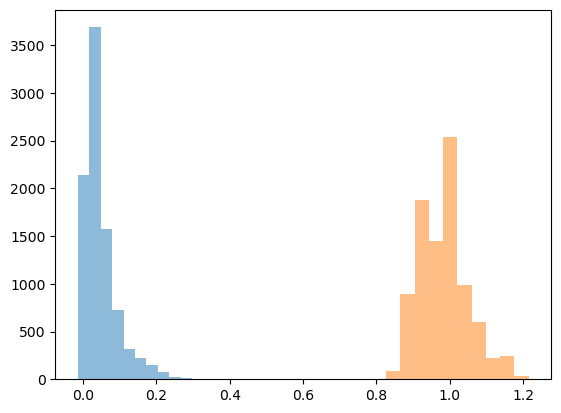

In [13]:
plt.hist(additive_gains[0].flatten(), alpha=0.5)
plt.hist(multiplicative_gains[0].flatten(), alpha=0.5)

0.01368521483109729


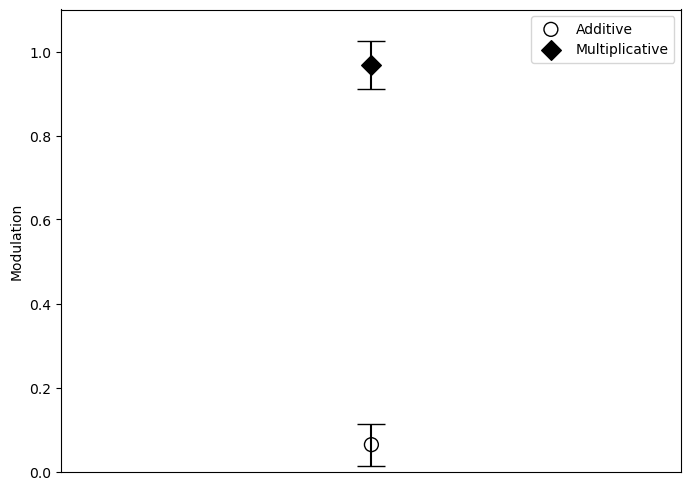

In [47]:
# TODO make scatter of mean and SD of gain terms
fig, ax = plt.subplots(1, 1, figsize=(8,6))
contrast_idx = 0
ax.scatter(1, np.mean(additive_gains[contrast_idx, :, :, :19, :]), label='Additive', marker='o', facecolors='none', color='k', s=100)
ax.scatter(1, np.mean(multiplicative_gains[contrast_idx, :, :, :19, :]), label='Multiplicative', color='k', marker='D', s=100)
ax.errorbar(1, np.mean(additive_gains[contrast_idx, :, :, :19, :]), yerr=np.std(additive_gains[0, :, :, :19, :]), color='k', capsize=10)
ax.errorbar(1, np.mean(multiplicative_gains[contrast_idx, :, :, :19, :]), yerr=np.std(multiplicative_gains[0, :, :, :19, :]), color='k', capsize=10)
ax.legend()
# check if it dips below zero
print(np.mean(additive_gains[contrast_idx, :, :, :19, :])-np.std(additive_gains[0, :, :, :19, :]))
ax.set_ylim(0, 1.1)
ax.set_xticks([])
ax.set_ylabel('Modulation')
plt.savefig('../manuscript_figures/fig2_additive_multiplicative_gains_mean_sd_new.pdf', format='pdf', bbox_inches='tight')

## Drifting gratings

In [ ]:
# define the stimuli
import math
import scipy.signal as signal

def create_grating(sw, ori, phase, wave, filt_size):
    """
    Inputs:
        sw: spatial wavelength (in pixels)
        ori: wave orientation (in degrees, [0-360])
        phase: wave phase (in degrees, [0-360])
        wave: type of wave ('sqr' or 'sin')
        imsize: image size (integer)
    Outputs:
        grating: numpy array of grating sitmulus with shape (imsize, imsize)
    """
    # Get x and y coordinates
    y, x = np.meshgrid(
        np.arange(filt_size[1]) - filt_size[1] // 2,
        np.arange(filt_size[0]) - filt_size[0] // 2,
    )

    # Get the appropriate gradient
    gradient = np.sin(ori * math.pi / 180) * y + np.cos(ori * math.pi / 180) * x

    # Plug gradient into wave function
    if wave == 'sin':
        grating = (np.sin((2 * math.pi * gradient) / sw + (phase * math.pi) / 180)+1)/2
    elif wave == 'sqr':
        grating = signal.square((2 * math.pi * gradient) / sw + (phase * math.pi) / 180)
    else:
        raise NotImplementedError

    # normalize the grating to unit norm
    # grating /= np.linalg.norm(grating)

    return grating

In [ ]:
# generate stimuli as drifting gratings and compute the response with Gabor filters

grating_orientation_arr = np.linspace(0, 360, 16, endpoint=False)
grating_phase_arr = np.linspace(0, 360, 16, endpoint=False)

drifting_gratings = np.zeros((len(grating_orientation_arr), len(grating_phase_arr), len(wavelength_arr), resolution_height, resolution_width))
for i, orientation in tqdm(enumerate(grating_orientation_arr)):
    print("orientation: " + str(orientation))
    for j, phase in enumerate(grating_phase_arr):
        for k, wavelength in enumerate(wavelength_arr):
            drifting_gratings[i, j, k] = create_grating(wavelength, orientation, phase, 'sin', filter_size)

In [ ]:
plt.imshow(drifting_gratings[0, 0, 2, :, :])
plt.colorbar()

In [ ]:
plt.imshow(gabor_filter_bank[0, 0, 2, 4, :, :])

# Contrast Tuning

In [ ]:
freq_arr

In [ ]:
# have 6 different examples
example_ori_idx = [0, 2, 4, 6, 7, 1]
example_phases = [0, 0, 0, 2, 2, 2]
example_wavelengths = [1, 2, 3, 1, 2, 3]

position_idx = 4
lambda_idx = 2
contrast_arr = np.logspace(-1, 3, 100)

from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(2, 3, figsize=(18, 12))
for idx in range(6):
    orientation_idx = example_ori_idx[idx]
    phase_idx = example_phases[idx]
    wavelength_idx = example_wavelengths[idx]

    sample_filter = gabor_filter_bank[orientation_idx, phase_idx, wavelength_idx, position_idx, :, :]

    sample_filter_optimal_k_stationary = optimal_k_arr_stationary[orientation_idx, phase_idx, wavelength_idx, position_idx, lambda_idx]
    sample_filter_optimal_L_stationary = optimal_L_arr_stationary[orientation_idx, phase_idx, wavelength_idx, position_idx, lambda_idx]
    sample_filter_optimal_k_moving = optimal_k_arr_moving[orientation_idx, phase_idx, wavelength_idx, position_idx, lambda_idx]
    sample_filter_optimal_L_moving = optimal_L_arr_moving[orientation_idx, phase_idx, wavelength_idx, position_idx, lambda_idx]

    # generate stimuli as drifting gratings and compute the response with Gabor filters

    filter_inputs = np.zeros((len(contrast_arr), resolution_height, resolution_width))
    for i, contrast in enumerate(contrast_arr):
        filter_inputs[i] = contrast*sample_filter
    
    # compute the responses
    filter_output = np.tensordot(sample_filter, filter_inputs, axes=([-2, -1], [-2, -1]))

    contrast_tuning_stationary = np.zeros(len(contrast_arr))
    contrast_tuning_moving = np.zeros(len(contrast_arr))

    # compute the responses of the filter to the drifting gratings
    for i, contrast in enumerate(contrast_arr):
        contrast_tuning_stationary[i] = logistic_func(filter_output[i], k=sample_filter_optimal_k_stationary, L=sample_filter_optimal_L_stationary)
        contrast_tuning_moving[i] = logistic_func(filter_output[i], k=sample_filter_optimal_k_moving, L=sample_filter_optimal_L_moving)
    
    X = contrast_tuning_stationary.reshape(-1, 1)
    y = contrast_tuning_moving
    reg = LinearRegression().fit(X, y)

    add_gain = reg.intercept_
    multi_gain = reg.coef_[0]

    # ax[i//3, i%3].plot(grating_orientation_arr, reg.predict(X), label='Predicted Moving', color='tab:blue', linestyle='--')
    ax[idx//3, idx%3].plot(contrast_arr, contrast_tuning_stationary, label='Stationary', color='tab:red')
    ax[idx//3, idx%3].plot(contrast_arr, contrast_tuning_moving, label='Moving', color='tab:blue')
    ax[idx//3, idx%3].set_xscale('log')
    # ax[idx//3, idx%3].text(180, 0.5, 'Additive gain: ' + str(np.round(add_gain, 2)))
    # ax[idx//3, idx%3].text(180, 0.45, 'Multiplicative gain: ' + str(np.round(multi_gain, 2)))
    ax[idx//3, idx%3].set_title('Orientation: ' + str(orientation_arr[orientation_idx]) + ', Phase: ' + str(phase_arr[phase_idx]) + ', Frequency: ' + str(freq_arr[wavelength_idx])+ '\nAdditive gain: ' + str(np.round(add_gain, 2)) + ', Multiplicative gain: ' + str(np.round(multi_gain, 2)))

In [ ]:
# compute the contrast tuning curve for all filters
# takes approx 40 minutes to run
contrast_arr = np.logspace(-1, 2, 100)
contrast_tuning_curves_stationary = np.zeros((len(orientation_arr), len(phase_arr), len(wavelength_arr[low_spatial_freq_idx]), len(position_arr), len(contrast_arr)))
contrast_tuning_curves_moving = np.zeros((len(orientation_arr), len(phase_arr), len(wavelength_arr[low_spatial_freq_idx]), len(position_arr), len(contrast_arr)))

for orientation_idx, orientation in tqdm(enumerate(orientation_arr)):
    print("orientation: " + str(orientation))
    for phase_idx, phase in tqdm(enumerate(phase_arr)):
        print("phase: " + str(phase))
        for wavelength_idx, wavelength in tqdm(enumerate(wavelength_arr[low_spatial_freq_idx])):
            print("wavelength: " + str(wavelength))
            for position_idx, position in enumerate(position_arr):
                sample_filter = gabor_filter_bank[orientation_idx, phase_idx, wavelength_idx, position_idx, :, :]

                sample_filter_optimal_k_stationary = optimal_k_arr_stationary[orientation_idx, phase_idx, wavelength_idx, position_idx, lambda_idx]
                sample_filter_optimal_L_stationary = optimal_L_arr_stationary[orientation_idx, phase_idx, wavelength_idx, position_idx, lambda_idx]
                sample_filter_optimal_k_moving = optimal_k_arr_moving[orientation_idx, phase_idx, wavelength_idx, position_idx, lambda_idx]
                sample_filter_optimal_L_moving = optimal_L_arr_moving[orientation_idx, phase_idx, wavelength_idx, position_idx, lambda_idx]

                # generate stimuli as drifting gratings and compute the response with Gabor filters

                filter_inputs = np.zeros((len(contrast_arr), resolution_height, resolution_width))
                for i, contrast in enumerate(contrast_arr):
                    filter_inputs[i] = contrast*sample_filter
                
                # compute the responses
                filter_output = np.tensordot(sample_filter, filter_inputs, axes=([-2, -1], [-2, -1]))

                contrast_tuning_stationary = np.zeros(len(contrast_arr))
                contrast_tuning_moving = np.zeros(len(contrast_arr))

                # compute the responses of the filter to the drifting gratings
                for i, contrast in enumerate(contrast_arr):
                    contrast_tuning_stationary[i] = logistic_func(filter_output[i], k=sample_filter_optimal_k_stationary, L=sample_filter_optimal_L_stationary)
                    contrast_tuning_moving[i] = logistic_func(filter_output[i], k=sample_filter_optimal_k_moving, L=sample_filter_optimal_L_moving)
                
                # normalize each tuning curve
                norm_factor = np.max([contrast_tuning_stationary, contrast_tuning_moving])
                contrast_tuning_stationary /= norm_factor
                contrast_tuning_moving /= norm_factor
                
                contrast_tuning_curves_stationary[orientation_idx, phase_idx, wavelength_idx, position_idx] = contrast_tuning_stationary
                contrast_tuning_curves_moving[orientation_idx, phase_idx, wavelength_idx, position_idx] = contrast_tuning_moving

In [ ]:
# load the precomputed contrast tuning curves
# Save results
WINDOW_LENGTH = 2
lambda_ = 1.0
contrast_arr = np.logspace(0, 3, 50)
contrast_arr = np.insert(contrast_arr, 0, 0)
contrast_tuning_curves_stationary = np.load(f'contrast_tuning_curves_stationary_window_length_{WINDOW_LENGTH}_lambda_{lambda_}.npy')
contrast_tuning_curves_moving = np.load(f'contrast_tuning_curves_moving_window_length_{WINDOW_LENGTH}_lambda_{lambda_}.npy')


In [ ]:
# plot the average contrast tuning curve
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(contrast_arr, np.mean(contrast_tuning_curves_stationary, axis=(0, 1, 2, 3)), label='Stationary', color='tab:red')
ax.plot(contrast_arr, np.mean(contrast_tuning_curves_moving, axis=(0, 1, 2, 3)), label='Moving', color='tab:blue')
ax.set_xscale('log')
ax.legend()
ax.set_ylim(0, 1.1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Contrast')
ax.set_ylabel('Normalized response')
plt.savefig('../manuscript_figures/avg_contrast_tuning_curve.pdf', format='pdf', bbox_inches='tight')

In [ ]:
# plot the average contrast tuning curve
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(contrast_arr/np.max(contrast_arr)*100, np.mean(contrast_tuning_curves_stationary, axis=(0, 1, 2, 3)), label='Stationary', color='tab:red')
ax.plot(contrast_arr/np.max(contrast_arr)*100, np.mean(contrast_tuning_curves_moving, axis=(0, 1, 2, 3)), label='Moving', color='tab:blue')
ax.set_xscale('log')
ax.legend()
ax.set_ylim(0, 1.1)
ax.set_xticks([0.1, 1, 10, 100], labels=['0.1', '1', '10', '100'])
# plot a break in the x-axis
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel('Contrast (%)')
ax.set_ylabel('Normalized response')
plt.savefig('../manuscript_figures/avg_contrast_tuning_curve_percent.pdf', format='pdf', bbox_inches='tight')

In [ ]:
# plot the average contrast tuning curve
fig, (ax2, ax) = plt.subplots(1, 2, figsize=(8, 6), sharey=True, gridspec_kw={'width_ratios': [1, 3]})
ax.plot(contrast_arr/np.max(contrast_arr)*100, np.mean(contrast_tuning_curves_stationary, axis=(0, 1, 2, 3)), label='Stationary', color='tab:red')
ax.plot(contrast_arr/np.max(contrast_arr)*100, np.mean(contrast_tuning_curves_moving, axis=(0, 1, 2, 3)), label='Moving', color='tab:blue')
ax2.plot(contrast_arr/np.max(contrast_arr)*100, np.mean(contrast_tuning_curves_stationary, axis=(0, 1, 2, 3)), label='Stationary', color='tab:red')
ax2.plot(contrast_arr/np.max(contrast_arr)*100, np.mean(contrast_tuning_curves_moving, axis=(0, 1, 2, 3)), label='Moving', color='tab:blue')
ax.set_xlim(contrast_arr[1]/np.max(contrast_arr)*100, contrast_arr[-1]/np.max(contrast_arr)*100)
ax2.set_xlim(0, 0.05)
ax.set_xscale('log')
# ax.set_xlim(1e0, 1e3)
ax.set_xticks([0.1, 1, 10, 100], labels=['0.1', '1', '10', '100'])
ax.legend()
# plot a break in the x-axis
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.set_ylim(0, 1.1)

# hide the spines between ax and ax2
ax.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)
# make the y ticks on ax invisible
ax.yaxis.set_visible(False)

d = .01  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)

kwargs.update(transform=ax2.transAxes)
ax2.plot((1-d, 1+d), (-d, +d), **kwargs)  # bottom-left diagonal


fig.supxlabel('Contrast (%)')
ax2.set_ylabel('Normalized response')
plt.savefig('../manuscript_figures/avg_contrast_tuning_curve_split.pdf', format='pdf', bbox_inches='tight')
plt.show()

### single example filter

In [ ]:
position_arr

In [ ]:
# compute the contrast tuning curve for a single filter
contrast_arr = 5*np.logspace(0, 2, 12)

orientation_idx = 3
phase_idx = 2
wavelength_idx = 8
position_idx = 4
lambda_idx = 2

sample_filter = gabor_filter = gabor_filter_func(
                    sigma=wavelength_arr[wavelength_idx]/3,
                    theta=orientation_arr[orientation_idx],
                    wavelength=wavelength_arr[wavelength_idx],
                    phase=phase_arr[phase_idx],
                    gamma=1,
                    filt_size=filter_size,
                    x_offset=position_arr[position_idx, 0],
                    y_offset=position_arr[position_idx, 1],
                )

sample_filter_optimal_k_stationary = optimal_k_arr_stationary[orientation_idx, phase_idx, wavelength_idx, position_idx, lambda_idx]
sample_filter_optimal_L_stationary = optimal_L_arr_stationary[orientation_idx, phase_idx, wavelength_idx, position_idx, lambda_idx]
sample_filter_optimal_k_moving = optimal_k_arr_moving[orientation_idx, phase_idx, wavelength_idx, position_idx, lambda_idx]
sample_filter_optimal_L_moving = optimal_L_arr_moving[orientation_idx, phase_idx, wavelength_idx, position_idx, lambda_idx]

# generate stimuli as drifting gratings and compute the response with Gabor filters

filter_inputs = np.zeros((len(contrast_arr), resolution_height, resolution_width))
for i, contrast in enumerate(contrast_arr):
    filter_inputs[i] = contrast*sample_filter

# add a zero contrast stimulus to the beginning of the array
filter_inputs = np.insert(filter_inputs, 0, np.zeros((resolution_height, resolution_width)), axis=0)

print(filter_inputs.shape)
print(sample_filter.shape)

# compute the responses
filter_output = np.tensordot(sample_filter, filter_inputs, axes=([-2, -1], [-2, -1]))

contrast_tuning_stationary = np.zeros(len(filter_inputs))
contrast_tuning_moving = np.zeros(len(filter_inputs))

# compute the responses of the filter to the drifting gratings
for i in range(len(filter_inputs)):
    contrast_tuning_stationary[i] = logistic_func(filter_output[i], k=sample_filter_optimal_k_stationary, L=sample_filter_optimal_L_stationary)
    contrast_tuning_moving[i] = logistic_func(filter_output[i], k=sample_filter_optimal_k_moving, L=sample_filter_optimal_L_moving)

# normalize each tuning curve
norm_factor = np.max([contrast_tuning_stationary, contrast_tuning_moving])
contrast_tuning_stationary /= norm_factor
contrast_tuning_moving /= norm_factor

In [ ]:
norm_contrast_arr = contrast_arr/np.max(contrast_arr)*100

In [ ]:
# use broken axis plot
cm = 1/2.54

fig, ax = plt.subplots(figsize=(6*cm, 6*cm))

norm_contrast_arr = contrast_arr/np.max(contrast_arr)*100
ax.plot(norm_contrast_arr, contrast_tuning_stationary[1:], label='Stationary', color='tab:red')
ax.plot(norm_contrast_arr, contrast_tuning_moving[1:], label='Moving', color='tab:blue')
ax.scatter(.7, contrast_tuning_stationary[0], color='tab:red')
ax.scatter(.7, contrast_tuning_moving[0], color='tab:blue')
ax.set_xscale('log')
ax.set_ylim(0)
ax.set_xlabel('Contrast (%)')
ax.set_ylabel('Normalized response')
# plt.xlim(.7, 100)
# remove the spliens from the top and right
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
orientation_idx = 3
phase_idx = 2
wavelength_idx = 8
position_idx = 4
lambda_idx = 2
plt.savefig(f'../manuscript_figures/fig2_contrast_tuning_curve_example_ori_{orientation_idx}_phase_{phase_idx}_freq_{wavelength_idx}_pos_{position_idx}_lambda_{lambda_idx}.svg', format='svg', bbox_inches='tight')

# Frequency selectivity

In [ ]:
wavelength_arr

In [ ]:
orientation = 0
phase = 0
position = [0, 0]

pixels_per_degree = 20

filter_size = (resolution_height, resolution_width)

different_freq_input = np.zeros((len(wavelength_arr), resolution_height, resolution_width))


for l, wavelength in enumerate(wavelength_arr):
    gabor_filter = gabor_filter_func(
        sigma=np.inf,
        theta=orientation,
        wavelength=wavelength,
        phase=phase,
        gamma=1,
        filt_size=filter_size,
        x_offset=position[0],
        y_offset=position[1],
    )
    different_freq_input[l] = gabor_filter

In [ ]:
plt.imshow(different_freq_input[20], cmap='gray')

In [ ]:
# pick a low spatial freq
low_idx = 8 # 35 # marm_perif_prob.argmax()
example_marm_perif_rf = gabor_filter_func(
        sigma=wavelength_arr[low_idx]/3,
        theta=orientation,
        wavelength=wavelength_arr[low_idx],
        phase=phase,
        gamma=1,
        filt_size=filter_size,
        x_offset=position[0],
        y_offset=position[1],
    )

# compute the reponse of the low spatial frequency filter with different frequency inputs
filter_output = np.tensordot(example_marm_perif_rf, different_freq_input, axes=([-2, -1], [-2, -1]))

In [ ]:
freq_arr[35]

In [ ]:
plt.plot(freq_arr, filter_output)
plt.xscale('log')